# Integration of spatial transcriptomics data - Nanopore

First reformat features, then work out h5 format to read in using built-in scanpy read_visium, then proceed using
scanpy - BBKNN

Florian Leuschner spatial (prelim data by Xue 4 slices of the same animal/heart @ 3 days after MI)


In [10]:
# modules

import os
import sys
import logging
import json
import gzip

from collections import defaultdict

def get_ipython_logger(logging_level='DEBUG', format_str='%(levelname)-8s : %(message)s'):

    level = logging.getLevelName(logging_level)
    formatter = logging.Formatter(format_str)
    
    logger = logging.getLogger()
    logger.setLevel(level)

    # clear whatever handlers were there
    while len(logger.handlers):
        logger.removeHandler(logger.handlers[0])
    
    #h_out = logging.StreamHandler(sys.stdout)
    h_err = logging.StreamHandler(sys.stderr)

    #logger.addHandler(h_out)
    logger.addHandler(h_err)

    for h in logger.handlers:
        h.setFormatter(formatter)

    return logger

logger = get_ipython_logger(logging_level='INFO')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [198]:
os.getpid()

4153

In [144]:
import scanpy as sc

import anndata

import numpy as np
import pandas as pd
import scipy as sp
import scipy.io

import bbknn
import scanorama

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

from scipy import stats

import scvi

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


INFO     : Global seed set to 0


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.ERROR) 

from matplotlib import colors

# from Scrublet
def darken_cmap(cmap, scale_factor):
    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii,0] = curcol[0] * scale_factor
        cdat[ii,1] = curcol[1] * scale_factor
        cdat[ii,2] = curcol[2] * scale_factor
        cdat[ii,3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
cmaps = darken_cmap(plt.cm.Reds, 0.9)

bone_reversed = plt.cm.get_cmap('bone_r')
copper_reversed = plt.cm.get_cmap('copper_r')
summer_reversed = plt.cm.get_cmap('summer_r')

In [4]:
# functions

def p_scatter(adata, x='n_counts', y='n_genes', hue='pct_mt', 
              xl='Count depth (raw)', yl='Number of genes', title='Fraction MT counts',
              mxx=None, mxy=None, show=False):
    ax = sc.pl.scatter(adata,
                       x, 
                       y, 
                       color=hue, 
                       show=show)
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    if mxx is not None:
        ax.set_xlim(0, mxx)
    if mxy is not None:
        ax.set_ylim(0, mxy)
        
    fig = ax.get_figure()
    return fig

def p_hist(adata, stat='count', x1='n_genes', x2='n_counts', x3='pct_mt', 
           xl1='No. of genes per cell', xl2='Counts per cell', xl3='MT read fraction per cell'):
    
    from matplotlib.offsetbox import AnchoredText
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    
    d = sns.histplot(adata.obs[x1], kde=True, ax=ax1, stat=stat)
    ax1.axvline(np.median(adata.obs[x1]), color='k', linestyle='--')
    ax1.set_ylabel('')
    ax1.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {int(np.median(adata.obs[x1]))}\nPeak {int(x[maxid])}\nMode {adata.obs[x1].mode().tolist()[0]}", 
                       loc="upper right", frameon=False, prop=dict(size=10))
    ax1.add_artist(anc)
    
    d = sns.histplot(adata.obs[x2], kde=True, ax=ax2, stat=stat)
    ax2.axvline(np.median(adata.obs[x2]), color='k', linestyle='--')
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {int(np.median(adata.obs[x2]))}\nPeak {int(x[maxid])}\nMode {adata.obs[x2].mode().tolist()[0]}", 
                       loc="upper right", frameon=False, prop=dict(size=10))
    ax2.add_artist(anc)
    
    d = sns.histplot(adata.obs[x3], kde=True, ax=ax3, stat=stat)
    ax3.axvline(np.median(adata.obs[x3]), color='k', linestyle='--')
    ax3.set_ylabel('')
    ax3.set_yticklabels([])
    
    x = d.lines[0].get_xdata() 
    y = d.lines[0].get_ydata() 
    maxid = np.argmax(y) 
    anc = AnchoredText(f"Median {np.median(adata.obs[x3]):.2}\nPeak {x[maxid]:.2}\nMode {adata.obs[x3].mode().tolist()[0]:.2}", 
                       loc="upper left", frameon=False, prop=dict(size=10))
    ax3.add_artist(anc)
    
    ax1.title.set_text(xl1)
    ax2.title.set_text(xl2)
    ax3.title.set_text(xl3)
    
    return fig


In [5]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):
    
    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # all `dataframe.columns`
            columns = dataframe.columns
        if dtypes: # pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns = gene_names.columns,
                index = gene_names.index,
            )

    for cluster_number in fraction_in_cluster_matrix.columns:
        dummy = adata_obj.raw.to_adata()
        dummy = dummy[:, adata_obj.uns[key]['names'][cluster_number].tolist()]
        
        subset_cluster = dummy[dummy.obs[DE_column].isin([cluster_number])]
        subset_notin_cluster = dummy[np.logical_not(dummy.obs[DE_column].isin([cluster_number]))]
   
        # Percent of cluster expressing
        if subset_cluster.shape[0] != 0:
            total_incluster = subset_cluster.shape[0]
        else: 
            total_incluster = np.nan

        if subset_notin_cluster.shape[0] != 0:
            total_outcluster = subset_notin_cluster.shape[0]
        else: 
            total_outcluster = np.nan
        
        fraction_in_cluster_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze].count_nonzero()/total_incluster) for gene_toanalyze in fraction_in_cluster_matrix.index]
        fraction_notin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze].count_nonzero()/total_outcluster) for gene_toanalyze in fraction_notin_cluster_matrix.index]

        # expression level (only by expressed)
        # in_cluster_expr_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze][subset_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in in_cluster_expr_matrix.index]
        # notin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze][subset_notin_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in notin_cluster_matrix.index]
    
        # expression_all in cluster
        allin_cluster_expr_matrix[cluster_number] = [(subset_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allin_cluster_expr_matrix.index]
        allnotin_cluster_matrix[cluster_number] = [(subset_notin_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allnotin_cluster_matrix.index]

    # generate results table
    result = adata_obj.uns[key]
    groups = result['names'].dtype.names
    result['pc_cells_in'] = to_tensor(fraction_in_cluster_matrix)
    result['pc_cells_out'] = to_tensor(fraction_notin_cluster_matrix)
    result['expr_in'] = to_tensor(allin_cluster_expr_matrix)
    result['expr_out'] = to_tensor(allnotin_cluster_matrix)
    
    results =pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pc_cells_in', 'pc_cells_out', "expr_in", "expr_out"]})

    return results


def makevector_topmarkers(anndata, top_n, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30, key='rank_genes_groups'):
    results=anndata.uns[key]
    clusters = results['names'].dtype.names
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & (results['pvals_adj'][cluster]<(pvals_adj_cutoff)))][0:top_n]
        top_genes.extend(topgenes_cluster)
    return(top_genes)

In [7]:
# see https://ccb.jhu.edu/software/stringtie/gffcompare.shtml for details

# tmap
# This tab delimited file lists the most closely matching reference transcript for each query transcript. 
# This file has one row per query transcript.

# refmap
# This file lists for each reference transcript, which query transcript either fully 
# or partially matches that reference transcript. This file has one row per reference transcript.

# how does this compare to  using the gtf file directly (parsing atttributes)?

dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore/transcriptomes/gffcompare'

tmap = os.path.join(dirloc, 'gffcmp.strg_merged.gtf.tmap')
tmap = pd.read_csv(tmap, sep='\t')

refmap = os.path.join(dirloc, 'gffcmp.strg_merged.gtf.refmap')
refmap = pd.read_csv(refmap, sep='\t')

# to match the reference gene name - in refmap
def get_id_gene_match(row):
    ref_gene = row['ref_gene']
    return {t:ref_gene for t in row['qry_id_list'].split('|')}

d = {j:k for i in refmap.apply(get_id_gene_match, axis=1) for j,k in i.items()}

# query qry_id, qry_gene_id, ref_id, and finally major_iso_id, else nothing matched
def get_ref_gene(row):
    for key in ['qry_id', 'qry_gene_id', 'ref_id', 'major_iso_id']:
        if row[key] in d:
            return d[row[key]]
    return row.qry_gene_id 

names = ['qry_id', 'ref_id', 'major_iso_id', 'qry_gene_id', 'ref_gene_id', 'class_code']
final_names = ['var_names', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code']

samples = !ls /prj/Florian_Leuschner_spatial/analysis/Nanopore/ | grep VX
dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'

for sample in samples:
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features.tsv.gz')
    df = pd.read_csv(filen, sep='\t', header=None, names=['qry_id'])
    df = pd.merge(df, tmap[names], on='qry_id', how='left')
    df['ref_gene_name'] = df.apply(get_ref_gene, axis=1)
    # define new entry as trx:ref_gene_name
    df['clean'] = df['ref_gene_name']
    df['var_names'] = df['qry_id'] + ':' + df['clean']
    df = df[final_names]
    # fill empty slots...
    for key in df:
        df.loc[df[key]=='-', key] = np.nan
    df.to_csv(os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features_named.tsv.gz'), 
              sep='\t', compression='gzip', index=False, header=False)

In [ ]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [207]:

dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore/transcriptomes/gffcompare'

tmap = os.path.join(dirloc, 'gffcmp.strg_merged.gtf.tmap')
tmap = pd.read_csv(tmap, sep='\t')

refmap = os.path.join(dirloc, 'gffcmp.strg_merged.gtf.refmap')
refmap = pd.read_csv(refmap, sep='\t')

In [208]:
tmap.head()
refmap.head()

ref_gene_id              ref_id class_code         qry_gene_id  \
0  ENSMUSG00000079800  ENSMUST00000096862          =  ENSMUSG00000079800   
1  ENSMUSG00000095092  ENSMUST00000177562          =  ENSMUSG00000095092   
2  ENSMUSG00000079192  ENSMUST00000111364          =  ENSMUSG00000079192   
3  ENSMUSG00000079794  ENSMUST00000115931          =  ENSMUSG00000079794   
4  ENSMUSG00000094799  ENSMUST00000115928          =  ENSMUSG00000094799   

               qry_id  num_exons  FPKM  TPM  cov   len        major_iso_id  \
0  ENSMUST00000096862          2   0.0  0.0  0.0  1271  ENSMUST00000096862   
1  ENSMUST00000177562          2   0.0  0.0  0.0   366  ENSMUST00000177562   
2  ENSMUST00000111364          2   0.0  0.0  0.0   255  ENSMUST00000111364   
3  ENSMUST00000115931          3   0.0  0.0  0.0   255  ENSMUST00000115931   
4  ENSMUST00000115928          2   0.0  0.0  0.0   366  ENSMUST00000115928   

  ref_match_len  
0          1271  
1           366  
2           255  
3           255  
4           366

ref_gene              ref_id class_code  \
0  AC125149.1  ENSMUST00000111364          =   
1  AC125149.4  ENSMUST00000115928          =   
2  AC125149.3  ENSMUST00000096862          =   
3  AC125149.5  ENSMUST00000177562          =   
4  AC125149.2  ENSMUST00000115931          =   

                             qry_id_list  
0  ENSMUSG00000079192|ENSMUST00000111364  
1  ENSMUSG00000094799|ENSMUST00000115928  
2  ENSMUSG00000079800|ENSMUST00000096862  
3  ENSMUSG00000095092|ENSMUST00000177562  
4  ENSMUSG00000079794|ENSMUST00000115931

In [222]:
tmap.shape
len(tmap.qry_id.unique())
refmap.shape
len(refmap.ref_id.unique())

(128095, 12)

128095

(117458, 4)

117406

In [214]:
tata = refmap.iloc[38:45,:]
tata

ref_gene              ref_id class_code  \
38       Vmn2r122  ENSMUST00000096791          =   
39       Vmn2r122  ENSMUST00000071277          =   
40       Vmn2r122  ENSMUST00000179115          =   
41       Vmn2r122  ENSMUST00000099422          =   
42        Il11ra2  ENSMUST00000179253          =   
43     CR974586.4  ENSMUST00000115904          =   
44  4933409K07Rik  ENSMUST00000179644          =   

                                          qry_id_list  
38  ENSMUSG00000096730|ENSMUST00000096791,ENSMUSG0...  
39  ENSMUSG00000096730|ENSMUST00000071277,ENSMUSG0...  
40  ENSMUSG00000096730|ENSMUST00000179115,ENSMUSG0...  
41              ENSMUSG00000096730|ENSMUST00000099422  
42              ENSMUSG00000095456|ENSMUST00000179253  
43                        MSTRG.32|ENSMUST00000115904  
44              ENSMUSG00000095552|ENSMUST00000179644

In [215]:
tata.assign(qry_id_list=tata.qry_id_list.str.split(",")).explode('qry_id_list')

ref_gene              ref_id class_code  \
38       Vmn2r122  ENSMUST00000096791          =   
38       Vmn2r122  ENSMUST00000096791          =   
39       Vmn2r122  ENSMUST00000071277          =   
39       Vmn2r122  ENSMUST00000071277          =   
40       Vmn2r122  ENSMUST00000179115          =   
40       Vmn2r122  ENSMUST00000179115          =   
41       Vmn2r122  ENSMUST00000099422          =   
42        Il11ra2  ENSMUST00000179253          =   
43     CR974586.4  ENSMUST00000115904          =   
44  4933409K07Rik  ENSMUST00000179644          =   

                              qry_id_list  
38  ENSMUSG00000096730|ENSMUST00000096791  
38  ENSMUSG00000096730|ENSMUST00000179115  
39  ENSMUSG00000096730|ENSMUST00000071277  
39  ENSMUSG00000096730|ENSMUST00000178970  
40  ENSMUSG00000096730|ENSMUST00000179115  
40  ENSMUSG00000096730|ENSMUST00000096791  
41  ENSMUSG00000096730|ENSMUST00000099422  
42  ENSMUSG00000095456|ENSMUST00000179253  
43            MSTRG.32|ENSMUST00000115904  
44  ENSMUSG00000095552|ENSMUST00000179644

In [216]:
tmap[tmap.qry_id=='ENSMUST00000096791']

ref_gene_id              ref_id class_code         qry_gene_id  \
44  ENSMUSG00000096730  ENSMUST00000096791          =  ENSMUSG00000096730   

                qry_id  num_exons  FPKM  TPM  cov   len        major_iso_id  \
44  ENSMUST00000096791          5   0.0  0.0  0.0  2950  ENSMUST00000179115   

   ref_match_len  
44          2950

In [223]:
# refmap.assign(qry_id_list=refmap.qry_id_list.str.split(",")).explode('qry_id_list')


In [225]:
########################


In [224]:
########################

gtf_field_names = [
    "seqname",
    "source",
    "feature",
    "start",
    "end",
    "score",
    "strand",
    "frame",
    "attributes"
]

gtf = pd.read_csv(os.path.join(dirloc, 'gffcmp.multi_exons.annotated.gtf'), sep='\t', header=None,
                 names=gtf_field_names)
gtf.head()

seqname   source     feature   start     end score strand frame  \
0  GL456210.1  ENSEMBL  transcript  123792  124928     .      +     .   
1  GL456210.1  ENSEMBL        exon  123792  123905     .      +     .   
2  GL456210.1  ENSEMBL        exon  124788  124928     .      +     .   
3  GL456210.1  ENSEMBL  transcript  147792  149707     .      +     .   
4  GL456210.1  ENSEMBL        exon  147792  147938     .      +     .   

                                          attributes  
0  transcript_id "ENSMUST00000111364"; gene_id "E...  
1  transcript_id "ENSMUST00000111364"; gene_id "E...  
2  transcript_id "ENSMUST00000111364"; gene_id "E...  
3  transcript_id "ENSMUST00000115928"; gene_id "E...  
4  transcript_id "ENSMUST00000115928"; gene_id "E...

In [226]:
gtf = parse_all_gtf_attributes(gtf, num_cpus=40)
trx = gtf[gtf.feature=='transcript'].copy()
trx.gene_name.fillna(trx.cmp_ref_gene, inplace=True)

In [277]:
####### check
dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'
!ls $dirloc/VX06_H61211c/analysis/feature_bc_matrix

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


In [311]:
# final named
# final_names = ['var_names', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code']
final_names = ['var_names', 'transcript_id', 'cmp_ref', 'gene_id', 'ref_gene_id', 'gene_name', 'class_code']
filen = os.path.join(dirloc, 'VX06_H61211c', 'analysis_bku', 'feature_bc_matrix', 'features_named.tsv.gz')
feat = pd.read_csv(filen, sep='\t', header=None, names=final_names)
feat.head(2)

var_names       transcript_id             cmp_ref  \
0  ENSMUST00000096862:AC125149.3  ENSMUST00000096862  ENSMUST00000096862   
1  ENSMUST00000177562:AC125149.5  ENSMUST00000177562  ENSMUST00000177562   

              gene_id         ref_gene_id   gene_name class_code  
0  ENSMUSG00000079800  ENSMUSG00000079800  AC125149.3          =  
1  ENSMUSG00000095092  ENSMUSG00000095092  AC125149.5          =

In [312]:
# try with old
filen = os.path.join(dirloc, 'VX06_H61211c', 'analysis_bku', 'feature_bc_matrix', 'features.tsv.gz')
df = pd.read_csv(filen, sep='\t', header=None, names=['transcript_id'])
df = pd.merge(df, trx[['transcript_id', 'cmp_ref', 'gene_id', 'ref_gene_id', 'gene_name', 'class_code']], on='transcript_id', how='left')
df.gene_name.fillna(df.gene_id, inplace=True)
df['var_names'] = df['transcript_id'] + ':' + df['gene_name']
df = df[final_names]

In [317]:
all(df.var_names==feat.var_names)

False

In [334]:
ind = df[['var_names', 'ref_gene_id']].merge(feat[['var_names', 'ref_gene_id']],indicator = True, how='outer').loc[lambda x : x['_merge']!='both']

In [335]:
ind[ind['_merge']=='left_only']

var_names         ref_gene_id     _merge
213              MSTRG.15.1:Pcmtd1                 NaN  left_only
230               MSTRG.24.1:Sntg1                 NaN  left_only
346               MSTRG.75.1:Prex2                 NaN  left_only
436               MSTRG.48.1:Rdh10                 NaN  left_only
584            MSTRG.116.1:Gm29506                 NaN  left_only
...                            ...                 ...        ...
126092           MSTRG.19242.1:Nhs                 NaN  left_only
126232        MSTRG.19272.1:Tmsb4x                 NaN  left_only
127569   MSTRG.19264.2:MSTRG.19264                 NaN  left_only
127589       MSTRG.19292.1:Gm21748  ENSMUSG00000096850  left_only
127590  ENSMUST00000179623:Gm21748  ENSMUSG00000096850  left_only

[1456 rows x 3 columns]

In [336]:
ind[ind['_merge']=='right_only']

var_names         ref_gene_id      _merge
127591               MSTRG.15.1:Pcmtd1  ENSMUSG00000051285  right_only
127592                MSTRG.24.1:Sntg1  ENSMUSG00000025909  right_only
127593                MSTRG.75.1:Prex2  ENSMUSG00000048960  right_only
127594                MSTRG.48.1:Rdh10  ENSMUSG00000025921  right_only
127595             MSTRG.116.1:Gm29506  ENSMUSG00000101227  right_only
...                                ...                 ...         ...
129042               MSTRG.19242.1:Nhs  ENSMUSG00000059493  right_only
129043            MSTRG.19272.1:Tmsb4x  ENSMUSG00000049775  right_only
129044           MSTRG.19264.2:Gm47283                 NaN  right_only
129045       MSTRG.19292.1:MSTRG.19292  ENSMUSG00000096850  right_only
129046  ENSMUST00000179623:MSTRG.19292  ENSMUSG00000096850  right_only

[1456 rows x 3 columns]

In [333]:
trx[trx.transcript_id=='MSTRG.19142.1']

seqname     source     feature      start        end score strand  \
982677    chrX  StringTie  transcript  136954988  136976874     .      -   

       frame                                         attributes  \
982677     .  transcript_id "MSTRG.19142.1"; gene_id "MSTRG....   

        transcript_id  ... gene_name         xloc         ref_gene_id  \
982677  MSTRG.19142.1  ...  Tmsb15b2  XLOC_033002  ENSMUSG00000089996   

                   cmp_ref class_code    tss_id exon_number contained_in  \
982677  ENSMUST00000180194          k  TSS77811         NaN          NaN   

       cmp_ref_gene ref_gene_name  
982677          NaN           NaN  

[1 rows x 21 columns]

In [308]:
df[(df.ref_gene_id.isna())] #(df.transcript_id.str.startswith('MSTRG')

transcript_id             cmp_ref      gene_id ref_gene_id gene_name  \
213        MSTRG.15.1  ENSMUST00000061280     MSTRG.15         NaN    Pcmtd1   
230        MSTRG.24.1  ENSMUST00000132064     MSTRG.24         NaN     Sntg1   
346        MSTRG.75.1  ENSMUST00000027056     MSTRG.75         NaN     Prex2   
416        MSTRG.38.1                 NaN     MSTRG.38         NaN       NaN   
436        MSTRG.48.1  ENSMUST00000027053     MSTRG.48         NaN     Rdh10   
...               ...                 ...          ...         ...       ...   
126925  MSTRG.19289.1                 NaN  MSTRG.19289         NaN       NaN   
126926  MSTRG.19289.2                 NaN  MSTRG.19289         NaN       NaN   
126980  MSTRG.19277.1                 NaN  MSTRG.19277         NaN       NaN   
127564  MSTRG.19274.1                 NaN  MSTRG.19274         NaN       NaN   
127569  MSTRG.19264.2                 NaN  MSTRG.19264         NaN       NaN   

       class_code  
213             x  
230             i  
346             x  
416             u  
436             x  
...           ...  
126925          u  
126926          u  
126980          u  
127564          u  
127569          u  

[2130 rows x 6 columns]

In [305]:
df[(df.gene_name.isna())]

transcript_id cmp_ref      gene_id ref_gene_id gene_name class_code
416        MSTRG.38.1     NaN     MSTRG.38         NaN       NaN          u
554        MSTRG.65.1     NaN     MSTRG.65         NaN       NaN          u
572        MSTRG.68.1     NaN     MSTRG.68         NaN       NaN          u
700        MSTRG.93.1     NaN     MSTRG.93         NaN       NaN          u
709       MSTRG.109.1     NaN    MSTRG.109         NaN       NaN          u
...               ...     ...          ...         ...       ...        ...
126925  MSTRG.19289.1     NaN  MSTRG.19289         NaN       NaN          u
126926  MSTRG.19289.2     NaN  MSTRG.19289         NaN       NaN          u
126980  MSTRG.19277.1     NaN  MSTRG.19277         NaN       NaN          u
127564  MSTRG.19274.1     NaN  MSTRG.19274         NaN       NaN          u
127569  MSTRG.19264.2     NaN  MSTRG.19264         NaN       NaN          u

[942 rows x 6 columns]

In [304]:
feat[(feat.ref_gene_id.isna())]

var_names         qry_id ref_id  qry_gene_id  \
416           MSTRG.38.1:MSTRG.38     MSTRG.38.1    NaN     MSTRG.38   
554           MSTRG.65.1:MSTRG.65     MSTRG.65.1    NaN     MSTRG.65   
572           MSTRG.68.1:MSTRG.68     MSTRG.68.1    NaN     MSTRG.68   
700           MSTRG.93.1:MSTRG.93     MSTRG.93.1    NaN     MSTRG.93   
709         MSTRG.109.1:MSTRG.109    MSTRG.109.1    NaN    MSTRG.109   
...                           ...            ...    ...          ...   
126925  MSTRG.19289.1:MSTRG.19289  MSTRG.19289.1    NaN  MSTRG.19289   
126926  MSTRG.19289.2:MSTRG.19289  MSTRG.19289.2    NaN  MSTRG.19289   
126980  MSTRG.19277.1:MSTRG.19277  MSTRG.19277.1    NaN  MSTRG.19277   
127564  MSTRG.19274.1:MSTRG.19274  MSTRG.19274.1    NaN  MSTRG.19274   
127569      MSTRG.19264.2:Gm47283  MSTRG.19264.2    NaN  MSTRG.19264   

       ref_gene_id ref_gene_name class_code  
416            NaN      MSTRG.38          u  
554            NaN      MSTRG.65          u  
572            NaN      MSTRG.68          u  
700            NaN      MSTRG.93          u  
709            NaN     MSTRG.109          u  
...            ...           ...        ...  
126925         NaN   MSTRG.19289          u  
126926         NaN   MSTRG.19289          u  
126980         NaN   MSTRG.19277          u  
127564         NaN   MSTRG.19274          u  
127569         NaN       Gm47283          u  

[942 rows x 7 columns]

Empty DataFrame
Columns: [var_names, qry_id, ref_id, qry_gene_id, ref_gene_id, ref_gene_name, class_code]
Index: []

In [299]:
tmap[tmap.qry_id=='MSTRG.48.1']
# COULD GENERATE A DICT/2 COLUMNS DF FROM TMAP FOR MISSING GENE_IDS (REFS)
# AND USE THIS TO ASSIGN MISSING ref_gene_id?????????? OR JUTS LEAVE AS IS.

# in all cases, we need to assign NaNs using fields always there, 
# or just for gene name, assign gene_id for nans, which is laway sthere, then create var names

ref_gene_id              ref_id class_code qry_gene_id  \
304  ENSMUSG00000025921  ENSMUST00000027053          x    MSTRG.48   

         qry_id  num_exons  FPKM  TPM  cov  len major_iso_id ref_match_len  
304  MSTRG.48.1          2   0.0  0.0  0.0  351   MSTRG.48.1          3587

In [300]:
feat[feat.qry_id=='MSTRG.48.1']

var_names      qry_id              ref_id qry_gene_id  \
436  MSTRG.48.1:Rdh10  MSTRG.48.1  ENSMUST00000027053    MSTRG.48   

            ref_gene_id ref_gene_name class_code  
436  ENSMUSG00000025921         Rdh10          x

In [303]:
trx[trx.transcript_id=='MSTRG.48.1'][[
 'transcript_id',
 'gene_id',
 'gene_name',
 'ref_gene_id',
 'cmp_ref',
 'class_code',
 'contained_in',
 'cmp_ref_gene',
 'ref_gene_name']]

transcript_id   gene_id gene_name ref_gene_id             cmp_ref  \
31691    MSTRG.48.1  MSTRG.48     Rdh10         NaN  ENSMUST00000027053   

      class_code contained_in cmp_ref_gene ref_gene_name  
31691          x          NaN        Rdh10           NaN

In [293]:
refmap[refmap.qry_id_list.str.contains('MSTRG.15.1', regex=False)]

Empty DataFrame
Columns: [ref_gene, ref_id, class_code, qry_id_list]
Index: []

In [295]:
# d['MSTRG.15.1']

In [ ]:
for sample in samples:
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features.tsv.gz')
    df = pd.read_csv(filen, sep='\t', header=None, names=['qry_id'])
    df = pd.merge(df, tmap[names], on='qry_id', how='left')
    df['ref_gene_name'] = df.apply(get_ref_gene, axis=1)
    # define new entry as trx:ref_gene_name
    df['clean'] = df['ref_gene_name']
    df['var_names'] = df['qry_id'] + ':' + df['clean']
    df = df[final_names]
    # fill empty slots...
    for key in df:
        df.loc[df[key]=='-', key] = np.nan
    df.to_csv(os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features_named.tsv.gz'), 
              sep='\t', compression='gzip', index=False, header=False)

In [230]:
len(trx.transcript_id.unique())

127591

In [272]:
trx[trx.gene_name.isna()].head()[[
 'transcript_id',
 'gene_id',
 'gene_name',
 'ref_gene_id',
 'cmp_ref',
 'class_code',
 'contained_in',
 'cmp_ref_gene',
 'ref_gene_name']]

transcript_id    gene_id gene_name ref_gene_id cmp_ref class_code  \
2311    MSTRG.65.1   MSTRG.65       NaN         NaN     NaN          u   
2620    MSTRG.93.1   MSTRG.93       NaN         NaN     NaN          u   
2652   MSTRG.109.1  MSTRG.109       NaN         NaN     NaN          u   
4747   MSTRG.150.1  MSTRG.150       NaN         NaN     NaN          u   
8537   MSTRG.279.1  MSTRG.279       NaN         NaN     NaN          u   

     contained_in cmp_ref_gene ref_gene_name  
2311          NaN          NaN           NaN  
2620          NaN          NaN           NaN  
2652          NaN          NaN           NaN  
4747          NaN          NaN           NaN  
8537          NaN          NaN           NaN

In [273]:
trx[trx.ref_gene_name.isna()].head()[[
 'transcript_id',
 'gene_id',
 'gene_name',
 'ref_gene_id',
 'cmp_ref',
 'class_code',
 'contained_in',
 'cmp_ref_gene',
 'ref_gene_name']]

transcript_id             gene_id   gene_name         ref_gene_id  \
0   ENSMUST00000111364  ENSMUSG00000079192  AC125149.1  ENSMUSG00000079192   
3   ENSMUST00000115928  ENSMUSG00000094799  AC125149.4  ENSMUSG00000094799   
6   ENSMUST00000096862  ENSMUSG00000079800  AC125149.3  ENSMUSG00000079800   
9   ENSMUST00000177562  ENSMUSG00000095092  AC125149.5  ENSMUSG00000095092   
12  ENSMUST00000115931  ENSMUSG00000079794  AC125149.2  ENSMUSG00000079794   

               cmp_ref class_code contained_in cmp_ref_gene ref_gene_name  
0   ENSMUST00000111364          =          NaN          NaN           NaN  
3   ENSMUST00000115928          =          NaN          NaN           NaN  
6   ENSMUST00000096862          =          NaN          NaN           NaN  
9   ENSMUST00000177562          =          NaN          NaN           NaN  
12  ENSMUST00000115931          =          NaN          NaN           NaN

In [ ]:
# I think we could just use the same gtf
# parse split fields, keep trx, get new var_name to be defined, qry_id=transcript_id, ref_id=cmp_ref, qry_gene_id=gene_id, ref_gene_id=ref_gene_id
# ref_gene_name=gene_name or cmp_ref_gene

# could we check if e.g. ref_id=cmp_ref from gtf and refmap/tmap? ref_gene_id=ref_gene_id or retrieve it?

final_names = ['var_names', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code']

# or something more simple

var_name, transcript_id 	gene_id 	gene_name 	ref_gene_id 	cmp_ref class_code 	

replace gene_name by cmp_ref_gene where nan

TODO: regenerate features for one given sample and check with existing features_named for diff!
    

In [254]:
trx[trx.transcript_id.isna()].head()

Empty DataFrame
Columns: [seqname, source, feature, start, end, score, strand, frame, attributes, transcript_id, gene_id, gene_name, xloc, ref_gene_id, cmp_ref, class_code, tss_id, exon_number, contained_in, cmp_ref_gene, ref_gene_name]
Index: []

[0 rows x 21 columns]

In [259]:
tmap[tmap.ref_id=='ENSMUST00000191045']

ref_gene_id              ref_id class_code qry_gene_id  \
638  ENSMUSG00000101227  ENSMUST00000191045          =   MSTRG.114   
640  ENSMUSG00000101227  ENSMUST00000191045          i   MSTRG.116   

                 qry_id  num_exons  FPKM  TPM  cov   len        major_iso_id  \
638  ENSMUST00000191045          4   0.0  0.0  0.0  2078  ENSMUST00000191045   
640         MSTRG.116.1          3   0.0  0.0  0.0   736         MSTRG.116.1   

    ref_match_len  
638          2078  
640          2078

In [261]:
refmap[refmap.ref_id=='ENSMUST00000191045']

ref_gene              ref_id class_code                   qry_id_list
3641  Gm29506  ENSMUST00000191045          =  MSTRG.114|ENSMUST00000191045

In [264]:
refmap[refmap.qry_id_list.str.contains('ENSMUST00000191045', regex=False)]

ref_gene              ref_id class_code                   qry_id_list
3641  Gm29506  ENSMUST00000191045          =  MSTRG.114|ENSMUST00000191045

In [249]:
tmap[tmap.qry_id=='MSTRG.65.1']

ref_gene_id ref_id class_code qry_gene_id      qry_id  num_exons  FPKM  \
391           -      -          u    MSTRG.65  MSTRG.65.1          2   0.0   

     TPM  cov  len major_iso_id ref_match_len  
391  0.0  0.0  614   MSTRG.65.1             -

In [242]:
# trx[trx.gene_name=='Sntg1']

In [250]:
refmap[refmap.qry_id_list.str.contains('MSTRG.65.1', regex=False)]

Empty DataFrame
Columns: [ref_gene, ref_id, class_code, qry_id_list]
Index: []

In [251]:
# refmap[refmap.ref_gene=='Sntg1']

In [243]:
# to match the reference gene name - in refmap
def get_id_gene_match(row):
    ref_gene = row['ref_gene']
    return {t:ref_gene for t in row['qry_id_list'].split('|')}

d = {j:k for i in refmap.apply(get_id_gene_match, axis=1) for j,k in i.items()}

In [253]:
# d['MSTRG.65.1']

In [ ]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [25]:
# convert to h5 
# we already have to structure with spatial directory linked 

import tables

dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'

for sample in samples:
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'matrix.mtx.gz')
    mat = scipy.io.mmread(filen).T.tocsr()
    
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features_named.tsv.gz')
    var = [l.decode('utf8').strip('\n').split('\t')[0] for l in gzip.open(filen, 'rb').readlines()]
    ids = [l.decode('utf8').strip('\n').split('\t')[1] for l in gzip.open(filen, 'rb').readlines()]
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'barcodes.tsv.gz')
    obs = [l.decode('utf8').strip('\n')+'-1' for l in gzip.open(filen, 'rb').readlines()] # add Ilumina -1
    
    filen = os.path.join(dirloc, sample, 'analysis', 'spatial', 'filtered_feature_bc_matrix.h5')
    h5file = tables.open_file(filen, mode="w", title="")

    group = h5file.create_group("/", 'matrix', '')
    h5file.create_carray(group, 'barcodes', obj=np.asarray(obs))
    h5file.create_earray(group, 'data', obj=mat.data)
    h5file.create_earray(group, 'indices', obj=mat.indices)
    h5file.create_earray(group, 'indptr', obj=mat.indptr)
    h5file.create_earray(group, 'shape', obj=np.asarray(mat.shape[::-1])) # transpose

    features = h5file.create_group(group, 'features', '')
    h5file.create_array(features, '_all_tag_keys', np.asarray(['genome']), "")
    h5file.create_carray(features, 'feature_type', obj=np.asarray(['Gene Expression']*mat.shape[1]))
    h5file.create_carray(features, 'genome', obj=np.asarray(['mm10']*mat.shape[1])) # hard coded
    h5file.create_carray(features, 'id', obj=np.asarray(ids))
    h5file.create_carray(features, 'name', obj=np.asarray(var))

    h5file.root._v_attrs.chemistry_description = "Spatial 3' v1 (Nanopore)"
    h5file.root._v_attrs.filetype = "matrix"
    h5file.root._v_attrs.library_ids = np.asarray([sample.encode('UTF-8')])

    h5file.close()


/matrix/barcodes (CArray(1993,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/data (EArray(661362,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/indices (EArray(661362,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/indptr (EArray(1994,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/shape (EArray(2,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/features/_all_tag_keys (Array(1,)) ''
  atom := StringAtom(itemsize=6, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None

/matrix/features/feature_type (CArray(127591,)) ''
  atom := StringAtom(itemsize=15, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4369,)

/matrix/features/genome (CArray(127591,)) ''
  atom := StringAtom(itemsize=4, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (16384,)

/matrix/features/id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/name (CArray(127591,)) ''
  atom := StringAtom(itemsize=35, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (1872,)

/matrix/barcodes (CArray(1958,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/data (EArray(1112931,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/indices (EArray(1112931,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/indptr (EArray(1959,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/shape (EArray(2,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/features/_all_tag_keys (Array(1,)) ''
  atom := StringAtom(itemsize=6, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None

/matrix/features/feature_type (CArray(127591,)) ''
  atom := StringAtom(itemsize=15, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4369,)

/matrix/features/genome (CArray(127591,)) ''
  atom := StringAtom(itemsize=4, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (16384,)

/matrix/features/id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/name (CArray(127591,)) ''
  atom := StringAtom(itemsize=35, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (1872,)

/matrix/barcodes (CArray(1950,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/data (EArray(1675713,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/indices (EArray(1675713,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/indptr (EArray(1951,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/shape (EArray(2,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/features/_all_tag_keys (Array(1,)) ''
  atom := StringAtom(itemsize=6, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None

/matrix/features/feature_type (CArray(127591,)) ''
  atom := StringAtom(itemsize=15, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4369,)

/matrix/features/genome (CArray(127591,)) ''
  atom := StringAtom(itemsize=4, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (16384,)

/matrix/features/id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/name (CArray(127591,)) ''
  atom := StringAtom(itemsize=35, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (1872,)

/matrix/barcodes (CArray(1964,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/data (EArray(2029473,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/indices (EArray(2029473,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/indptr (EArray(1965,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/shape (EArray(2,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/features/_all_tag_keys (Array(1,)) ''
  atom := StringAtom(itemsize=6, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None

/matrix/features/feature_type (CArray(127591,)) ''
  atom := StringAtom(itemsize=15, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4369,)

/matrix/features/genome (CArray(127591,)) ''
  atom := StringAtom(itemsize=4, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (16384,)

/matrix/features/id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/name (CArray(127591,)) ''
  atom := StringAtom(itemsize=35, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (1872,)

In [338]:
# testing tables with all features

final_names = [
    'var_names', 
    'transcript_id', 
    'cmp_ref', 
    'gene_id', 
    'ref_gene_id', 
    'gene_name', 
    'class_code']

dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'
sample = 'VX06_H61211c'
filen = os.path.join(dirloc, sample, 'analysis_bku', 'feature_bc_matrix', 'matrix.mtx.gz')
mat = scipy.io.mmread(filen).T.tocsr()
    
filen = os.path.join(dirloc, sample, 'analysis_bku', 'feature_bc_matrix', 'features_named.tsv.gz')
var = [l.decode('utf8').strip('\n').split('\t')[0] for l in gzip.open(filen, 'rb').readlines()] # >>>>>>> OPTION ADD all?
ids = [l.decode('utf8').strip('\n').split('\t')[1] for l in gzip.open(filen, 'rb').readlines()]
ids1 = [l.decode('utf8').strip('\n').split('\t')[2] for l in gzip.open(filen, 'rb').readlines()]
ids2 = [l.decode('utf8').strip('\n').split('\t')[3] for l in gzip.open(filen, 'rb').readlines()]
ids3 = [l.decode('utf8').strip('\n').split('\t')[4] for l in gzip.open(filen, 'rb').readlines()]
ids4 = [l.decode('utf8').strip('\n').split('\t')[5] for l in gzip.open(filen, 'rb').readlines()]
ids5 = [l.decode('utf8').strip('\n').split('\t')[6] for l in gzip.open(filen, 'rb').readlines()]

filen = os.path.join(dirloc, sample, 'analysis_bku', 'feature_bc_matrix', 'barcodes.tsv.gz')
obs = [l.decode('utf8').strip('\n')+'-1' for l in gzip.open(filen, 'rb').readlines()] # >>>>>>> OPTION add Ilumina -1 TO ALSO MATCH TISSUE POSITIONS cvs

In [346]:
chk = pd.read_csv(os.path.join(dirloc, sample, 'analysis_bku', 'feature_bc_matrix', 'features_named.tsv.gz'),
                  header=None, names=final_names, sep='\t')

In [350]:
chk[chk.ref_gene_id.isna()]

var_names  transcript_id cmp_ref      gene_id  \
416           MSTRG.38.1:MSTRG.38     MSTRG.38.1     NaN     MSTRG.38   
554           MSTRG.65.1:MSTRG.65     MSTRG.65.1     NaN     MSTRG.65   
572           MSTRG.68.1:MSTRG.68     MSTRG.68.1     NaN     MSTRG.68   
700           MSTRG.93.1:MSTRG.93     MSTRG.93.1     NaN     MSTRG.93   
709         MSTRG.109.1:MSTRG.109    MSTRG.109.1     NaN    MSTRG.109   
...                           ...            ...     ...          ...   
126925  MSTRG.19289.1:MSTRG.19289  MSTRG.19289.1     NaN  MSTRG.19289   
126926  MSTRG.19289.2:MSTRG.19289  MSTRG.19289.2     NaN  MSTRG.19289   
126980  MSTRG.19277.1:MSTRG.19277  MSTRG.19277.1     NaN  MSTRG.19277   
127564  MSTRG.19274.1:MSTRG.19274  MSTRG.19274.1     NaN  MSTRG.19274   
127569      MSTRG.19264.2:Gm47283  MSTRG.19264.2     NaN  MSTRG.19264   

       ref_gene_id    gene_name class_code  
416            NaN     MSTRG.38          u  
554            NaN     MSTRG.65          u  
572            NaN     MSTRG.68          u  
700            NaN     MSTRG.93          u  
709            NaN    MSTRG.109          u  
...            ...          ...        ...  
126925         NaN  MSTRG.19289          u  
126926         NaN  MSTRG.19289          u  
126980         NaN  MSTRG.19277          u  
127564         NaN  MSTRG.19274          u  
127569         NaN      Gm47283          u  

[942 rows x 7 columns]

In [353]:
var[416]
ids1[416]

'MSTRG.38.1:MSTRG.38'

''

In [354]:
filen = os.path.join(dirloc, sample, 'analysis_bku', 'test.h5')
h5file = tables.open_file(filen, mode="w", title="")

group = h5file.create_group("/", 'matrix', '')
h5file.create_carray(group, 'barcodes', obj=np.asarray(obs))
h5file.create_earray(group, 'data', obj=mat.data)
h5file.create_earray(group, 'indices', obj=mat.indices)
h5file.create_earray(group, 'indptr', obj=mat.indptr)
h5file.create_earray(group, 'shape', obj=np.asarray(mat.shape[::-1])) # transpose

features = h5file.create_group(group, 'features', '')
h5file.create_array(features, '_all_tag_keys', np.asarray(['genome']), "")
h5file.create_carray(features, 'feature_type', obj=np.asarray(['Gene Expression']*mat.shape[1]))
h5file.create_carray(features, 'genome', obj=np.asarray(['mm10']*mat.shape[1])) # hard coded
h5file.create_carray(features, 'id', obj=np.asarray(ids))
h5file.create_carray(features, 'name', obj=np.asarray(var))

# THIS IS CURRENTL USELESS!
# besides read_visumj takes the ids as gene_ids, so we pass this one or we don't both and anyway remove it afterwards, adn join with features_annotated
# but when loading into scanpy, need to read the features_annoated, and add the relevant fields 
# cmp_ref 	gene_id 	ref_gene_id 	gene_name 	class_code
h5file.create_carray(features, 'cmp_ref', obj=np.asarray(ids1))
h5file.create_carray(features, 'gene_id', obj=np.asarray(ids2))
h5file.create_carray(features, 'ref_gene_id', obj=np.asarray(ids3))
h5file.create_carray(features, 'gene_name', obj=np.asarray(ids4))
h5file.create_carray(features, 'class_code', obj=np.asarray(ids5))

h5file.root._v_attrs.chemistry_description = "Spatial 3' v1 (Nanopore)"
h5file.root._v_attrs.filetype = "matrix"
h5file.root._v_attrs.library_ids = np.asarray([sample.encode('UTF-8')])

h5file.close()

# PLAN:
#     
# 

/matrix/barcodes (CArray(1950,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/data (EArray(1675713,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/indices (EArray(1675713,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/indptr (EArray(1951,)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16384,)

/matrix/shape (EArray(2,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

/matrix/features/_all_tag_keys (Array(1,)) ''
  atom := StringAtom(itemsize=6, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None

/matrix/features/feature_type (CArray(127591,)) ''
  atom := StringAtom(itemsize=15, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4369,)

/matrix/features/genome (CArray(127591,)) ''
  atom := StringAtom(itemsize=4, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (16384,)

/matrix/features/id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/name (CArray(127591,)) ''
  atom := StringAtom(itemsize=35, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (1872,)

/matrix/features/cmp_ref (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/gene_id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/ref_gene_id (CArray(127591,)) ''
  atom := StringAtom(itemsize=18, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (3640,)

/matrix/features/gene_name (CArray(127591,)) ''
  atom := StringAtom(itemsize=16, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (4096,)

/matrix/features/class_code (CArray(127591,)) ''
  atom := StringAtom(itemsize=1, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (65536,)

In [357]:
adata_chk = sc.read_visium(os.path.join(dirloc, sample, 'analysis_bku', 'spatial'),
                           count_file='test.h5',
                           library_id='library_id') 
# adata.var_names_make_unique()

reading /prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis_bku/spatial/test.h5
 (0:00:00)


In [358]:
adata_chk

AnnData object with n_obs × n_vars = 1950 × 127591
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [360]:
adata_chk.var

gene_ids    feature_types genome
ENSMUST00000096862:AC125149.3   ENSMUST00000096862  Gene Expression   mm10
ENSMUST00000177562:AC125149.5   ENSMUST00000177562  Gene Expression   mm10
ENSMUST00000111364:AC125149.1   ENSMUST00000111364  Gene Expression   mm10
ENSMUST00000115931:AC125149.2   ENSMUST00000115931  Gene Expression   mm10
ENSMUST00000115928:AC125149.4   ENSMUST00000115928  Gene Expression   mm10
...                                            ...              ...    ...
MSTRG.19264.18:Gm47283              MSTRG.19264.18  Gene Expression   mm10
ENSMUST00000238471:Gm47283      ENSMUST00000238471  Gene Expression   mm10
MSTRG.19264.20:Gm47283              MSTRG.19264.20  Gene Expression   mm10
MSTRG.19292.1:MSTRG.19292            MSTRG.19292.1  Gene Expression   mm10
ENSMUST00000179623:MSTRG.19292  ENSMUST00000179623  Gene Expression   mm10

[127591 rows x 3 columns]

In [86]:
samples

['VX06_H61211a', 'VX06_H61211b', 'VX06_H61211c', 'VX06_H61211d']

In [193]:
#####################################################################################################################################
# issue with matrix
# that is the old data now under analysis_bku
quant = pd.read_csv('/prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis/salmon/quant.sf', sep='\t')

In [199]:
quant.shape

(127591, 1951)

In [204]:
quant.isnull().values.any()

True

In [200]:
quant[[q for q in quant if q in ['CATCTTACACCACCTC', 'TTGTTAGCAAATTCGA', 'TTGTTGTGTGTCAAGA']]]

CATCTTACACCACCTC  TTGTTAGCAAATTCGA  TTGTTGTGTGTCAAGA
0                    0.0               0.0               0.0
1                    0.0               0.0               0.0
2                    0.0               0.0               0.0
3                    0.0               0.0               0.0
4                    0.0               0.0               0.0
...                  ...               ...               ...
127586               0.0               NaN               NaN
127587               0.0               NaN               NaN
127588               0.0               NaN               NaN
127589               0.0               NaN               NaN
127590               0.0               NaN               NaN

[127591 rows x 3 columns]

In [206]:
# quant_new = pd.read_csv('/prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis/salmon/quant.sf', sep='\t')
quant_new = pd.read_csv('/prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis/tmp/quant_final.sf', sep='\t')
quant_new.shape
quant_new.isnull().values.any()
quant_new[[q for q in quant_new if q in ['CATCTTACACCACCTC', 'TTGTTAGCAAATTCGA', 'TTGTTGTGTGTCAAGA']]]

(127591, 1951)

False

CATCTTACACCACCTC  TTGTTAGCAAATTCGA  TTGTTGTGTGTCAAGA
0                    0.0               0.0               0.0
1                    0.0               0.0               0.0
2                    0.0               0.0               0.0
3                    0.0               0.0               0.0
4                    0.0               0.0               0.0
...                  ...               ...               ...
127586               0.0               0.0               0.0
127587               0.0               0.0               0.0
127588               0.0               0.0               0.0
127589               0.0               0.0               0.0
127590               0.0               0.0               0.0

[127591 rows x 3 columns]

In [201]:
quantCAT = pd.read_csv('/prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis/salmon/CATCTTACACCACCTC_sorted/quant.sf', sep='\t')

In [202]:
quantCAT.shape

(127591, 5)

In [203]:
quantCAT.isnull().values.any()

False

In [87]:
#####################################################################################################################################

In [88]:
names = ['var_names', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code']

def read_and_qc(sample, library_id, dirloc, outloc,
                mt_genes, mt_frac_thr,
                min_counts, max_counts, min_genes, max_genes, min_cells,
                plot=False, no_qc=False):
    
    # load data into AnnData fmt
    # use the built-in read_visium
    # genome=None Filter expression to genes within this genome
    # source_image_path=None Path to the high-resolution tissue image spatial/tissue_hires_image.png ?
    # load_images=True by default
    adata = sc.read_visium(os.path.join(dirloc, sample, 'analysis', 'spatial'),
                           count_file='filtered_feature_bc_matrix.h5',
                           library_id=library_id) 
    adata.var_names_make_unique()
    
    # add to adata.obs
    filen = os.path.join(dirloc, sample, 'analysis', 'feature_bc_matrix', 'features_named.tsv.gz')
    var = pd.read_csv(filen, sep='\t', header=None, names=names[1:], index_col=0)
    adata.var = adata.var.join(var)
    del adata.var['gene_ids']

    # We need to fix this <<<<<<<<<<<<<<<<<<<
    if sample == 'VX06_H61211c':
        delete = ['CATCTTACACCACCTC-1',
        'TTGTTAGCAAATTCGA-1',
        'TTGTTGTGTGTCAAGA-1']
        adata = adata[~adata.obs_names.isin(delete),:]

    if sample == 'VX06_H61211d':
        delete = ['GGCTGAAATAGCAAAG-1',
        'TTGTTTGTGTAAATTC-1']
        adata = adata[~adata.obs_names.isin(delete),:]
    
    
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['n_transcripts'] = (adata.X > 0).sum(1)
    mito_genes = adata.var.ref_gene_name.str.startswith('mt-', na=False)
    adata.obs['pct_mt'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

    logger.info(f"{sample}: View of AnnData object with n_obs × n_vars {adata.shape}")
    
    if plot:
        fig = p_scatter(adata, y='n_transcripts', yl='No. of transcripts')
        filen = os.path.join(outloc, 'results', 'figures', f"scatter_pre_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        fig = p_hist(adata, x1='n_transcripts', xl1='No. of transcripts per spot', xl2='Counts per spot')
        filen = os.path.join(outloc, 'results', 'figures', f"hist_pre_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        logger.info(f"{name}: View of AnnData object with n_obs × n_vars {adata.shape}")
        
    if no_qc:
        return adata
        
    # filter
    adata = adata[adata.obs['pct_mt'] < mt_frac_thr]
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_cells(adata, max_counts=max_counts)
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, max_genes=max_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    if plot:
        fig = p_scatter(adata, y='n_transcripts', yl='No. of transcripts')
        filen = os.path.join(outloc, 'results', 'figures', f"scatter_post_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")

        fig = p_hist(adata, x1='n_transcripts', xl1='No. of transcripts per spot', xl2='Counts per spot')
        filen = os.path.join(outloc, 'results', 'figures', f"hist_post_{sample}.png")
        fig.savefig(filen, bbox_inches = "tight")
    
    logger.info(f"{sample}: View of AnnData object with n_obs × n_vars {adata.shape}")
        
    return adata


In [170]:
# I/O

dirloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'
outloc = '/prj/Florian_Leuschner_spatial/analysis/Nanopore'

outname = 'bbknn'

# Normalization standard workflow
# We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes. 
# The variance in molecular counts across spots is not just technical in nature, but also is dependent on the tissue anatomy.
# More appropriate methods such as SCTransform should probably be used.
target_sum = 1e4

# Read the data into anndata objects
# use filtered visium dataset, the output of spaceranger that contains only spots within the tissue slice
slides = []
for s in samples:
    slide = read_and_qc(s, s.split('_')[1], dirloc=dirloc, outloc=outloc,
                        mt_genes='mt-', mt_frac_thr=0.4,
                        min_counts=100, max_counts=4000, min_genes=50, max_genes=2000, min_cells=2,
                        plot=False, no_qc=True)
    # # first concatenate, then qc, normalise, and integrate
    # slide.layers['counts'] = slide.X.copy() # if subset=True, this is also sliced, only raw atribute is safe
    # sc.pp.normalize_total(slide, 
    #                       target_sum=target_sum, 
    #                       exclude_highly_expressed=True)
    # sc.pp.log1p(slide)
    # slide.raw = slide
    # sc.pp.highly_variable_genes(slide, subset=False) 

    slides.append(slide)
    

reading /prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211a/analysis/spatial/filtered_feature_bc_matrix.h5
 (0:00:00)
/tmp/ipykernel_4153/3032680634.py:40: RuntimeWarning: invalid value encountered in true_divide
  adata.obs['pct_mt'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
INFO     : VX06_H61211a: View of AnnData object with n_obs × n_vars (1993, 127591)
reading /prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211b/analysis/spatial/filtered_feature_bc_matrix.h5
 (0:00:00)
INFO     : VX06_H61211b: View of AnnData object with n_obs × n_vars (1958, 127591)
reading /prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211c/analysis/spatial/filtered_feature_bc_matrix.h5
 (0:00:00)
Trying to set attribute `.obs` of view, copying.
INFO     : VX06_H61211c: View of AnnData object with n_obs × n_vars (1947, 127591)
reading /prj/Florian_Leuschner_spatial/analysis/Nanopore/VX06_H61211d/analysis/spatial/filtered_feature_bc_matrix.h5
 (0:00:00)


In [171]:
samples

['VX06_H61211a', 'VX06_H61211b', 'VX06_H61211c', 'VX06_H61211d']

In [172]:
# perform additional filtering 
# either here before concatenating, or first concatenate, and filter afterwards

mt_frac_thr = 0.4
min_counts = {'VX06_H61211a': 100, 
              'VX06_H61211b': 100, 
              'VX06_H61211c': 100, 
              'VX06_H61211d': 100}
max_counts = {'VX06_H61211a': 2000, 
              'VX06_H61211b': 2500, 
              'VX06_H61211c': 4000, 
              'VX06_H61211d': 4000}
min_genes = {'VX06_H61211a': 100, 
             'VX06_H61211b': 100, 
             'VX06_H61211c': 100, 
             'VX06_H61211d': 100}
max_genes = {'VX06_H61211a': 1000, 
             'VX06_H61211b': 1500, 
             'VX06_H61211c': 2000, 
             'VX06_H61211d': 2000}
min_cells = 3

for i, name in enumerate(samples):
    adata = slides[i]
    adata = adata[adata.obs['pct_mt'] < mt_frac_thr]
    
    sc.pp.filter_cells(adata, min_counts=min_counts[name])
    sc.pp.filter_cells(adata, max_counts=max_counts[name])
    sc.pp.filter_cells(adata, min_genes=min_genes[name])
    sc.pp.filter_cells(adata, max_genes=max_genes[name])
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    slides[i] = adata

filtered out 109 cells that have less than 100 counts
Trying to set attribute `.obs` of view, copying.
filtered out 9 cells that have more than 2000 counts
filtered out 53 cells that have less than 100 genes expressed
filtered out 8 cells that have more than 1000 genes expressed
filtered out 109225 genes that are detected in less than 3 cells
filtered out 53 cells that have less than 100 counts
Trying to set attribute `.obs` of view, copying.
filtered out 35 cells that have more than 2500 counts
filtered out 24 cells that have less than 100 genes expressed
filtered out 105790 genes that are detected in less than 3 cells
filtered out 5 cells that have less than 100 counts
Trying to set attribute `.obs` of view, copying.
filtered out 7 cells that have more than 4000 counts
filtered out 7 cells that have less than 100 genes expressed
filtered out 1 cells that have more than 2000 genes expressed
filtered out 102724 genes that are detected in less than 3 cells
filtered out 5 cells that have

In [ ]:
## Comparison of Illumina and Nanopore data

In [111]:
filen = '/prj/Florian_Leuschner_spatial/analysis/Illumina/data/clusters_bbknn.h5ad'
illumina = sc.read_h5ad(filen)

adata
illumina

AnnData object with n_obs × n_vars = 7422 × 11021
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'n_genes', 'library_id', 'leiden_rr', 'clusters'
    var: 'feature_types', 'genome', 'qry_id', 'qry_gene_id', 'ref_gene_name', 'class_code', 'ref_id-H61211a', 'ref_gene_id-H61211a', 'n_cells-H61211a', 'ref_id-H61211b', 'ref_gene_id-H61211b', 'n_cells-H61211b', 'ref_id-H61211c', 'ref_gene_id-H61211c', 'n_cells-H61211c', 'ref_id-H61211d', 'ref_gene_id-H61211d', 'n_cells-H61211d', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'library_id_colors', 'neighbors', 'leiden', 'umap', 'clusters_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_explained'
    obsp: 'distances', 'connectivities'

AnnData object with n_obs × n_vars = 7708 × 8076
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes', 'pct_mt', 'library_id', 'leiden_rr', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-A1', 'n_cells-B1', 'n_cells-C1', 'n_cells-D1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'library_id_colors', 'neighbors', 'pca', 'ranked_clusters', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'X_explained'
    obsp: 'connectivities', 'distances'

In [126]:
# restrict Nanopore to common set of barcodes for comparison below (counts, etc.), also look at the set of Nanopore-only barcodes

# DECIDE WHICH ONE...
# we should reformat this into the h5 object 
adata.obs_names = adata.obs_names.str.replace('H61211a', 'A1')
adata.obs_names = adata.obs_names.str.replace('H61211b', 'B1')
adata.obs_names = adata.obs_names.str.replace('H61211c', 'C1')
adata.obs_names = adata.obs_names.str.replace('H61211d', 'D1')

# common barcoded
idx = illumina.obs.reindex(adata.obs.index).dropna().index
# nanopore only
nanopore_only_barcodes = adata.obs_names[~adata.obs_names.isin(idx)]
nanopore = adata[adata.obs_names.isin(nanopore_only_barcodes), :]
# common AnnData for Illumina and Nanopore
illumina_matching = illumina[illumina.obs_names.isin(idx), :]
adata_matching = adata[adata.obs_names.isin(idx), :]


In [127]:
a = illumina_matching.obs[['n_counts', 'n_genes', 'pct_mt']].copy()
a.rename(columns={'n_counts': 'Illumina counts (genes)', 'n_genes': 'Illumina genes', 'pct_mt': 'Illumina MT pct'}, inplace=True)

b = adata_matching.obs[['n_counts', 'n_transcripts', 'pct_mt']].copy()
b.rename(columns={'n_counts': 'Nanopore counts (transcripts)', 'n_transcripts': 'Nanopore transcripts', 'pct_mt': 'Nanopore MT pct'}, inplace=True)

data = pd.concat([a, b], axis=1)

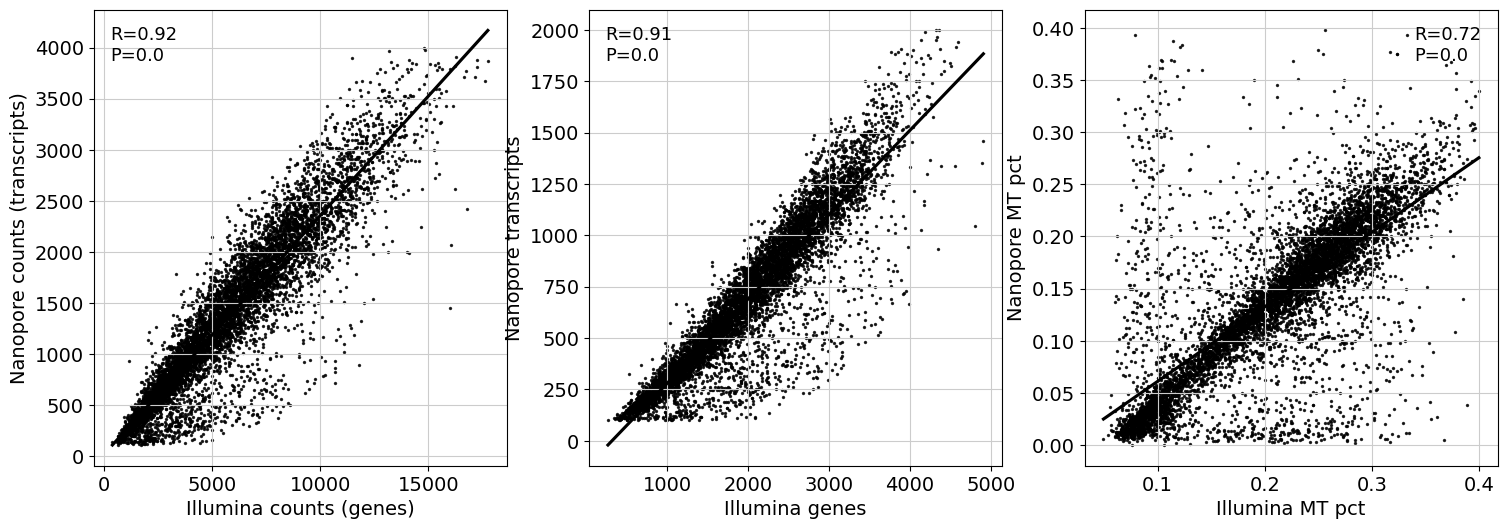

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

slope, intercept, r_value, pv, se = stats.linregress(data['Illumina counts (genes)'],data['Nanopore counts (transcripts)'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina counts (genes)", y="Nanopore counts (transcripts)", data=data, ax=ax1,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
slope, intercept, r_value, pv, se = stats.linregress(data['Illumina genes'],data['Nanopore transcripts'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina genes", y="Nanopore transcripts", data=data, ax=ax2,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    

slope, intercept, r_value, pv, se = stats.linregress(data['Illumina MT pct'],data['Nanopore MT pct'])
# sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
#       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
sns.regplot(x="Illumina MT pct", y="Nanopore MT pct", data=data, ax=ax3,
      ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
for item in leg.legendHandles:
    item.set_visible(False)
    
# filen = os.path.join(figloc, f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.png")
filen = os.path.join(outloc, 'results', 'figures', f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.pdf")
fig.savefig(filen, bbox_inches = "tight")

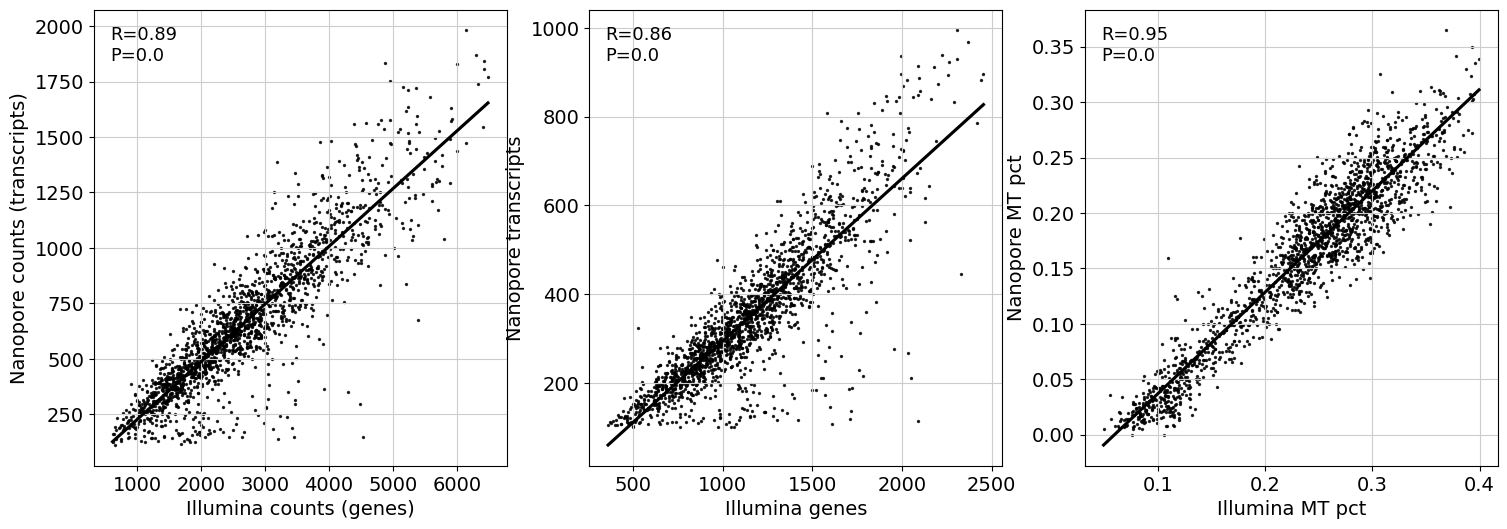

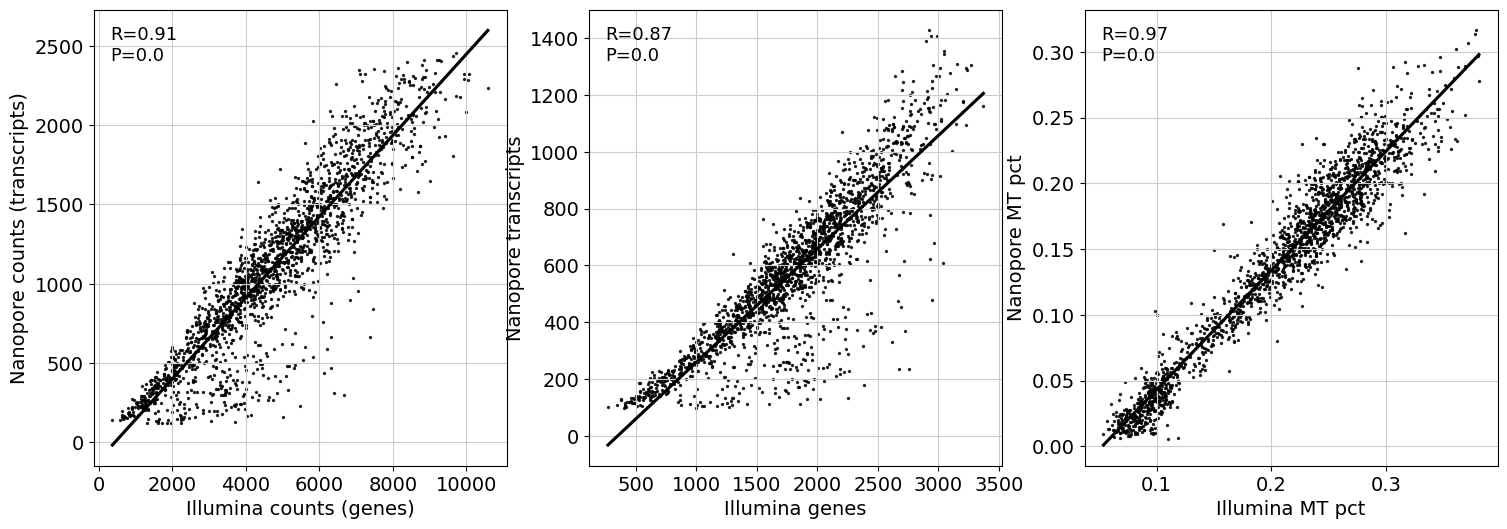

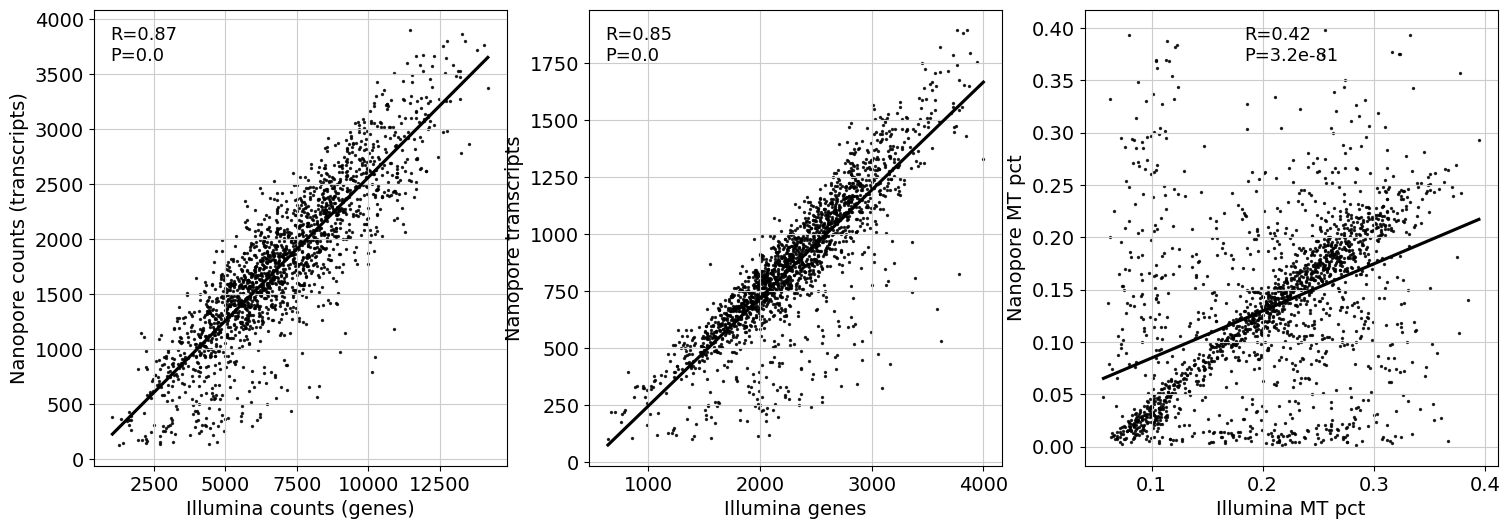

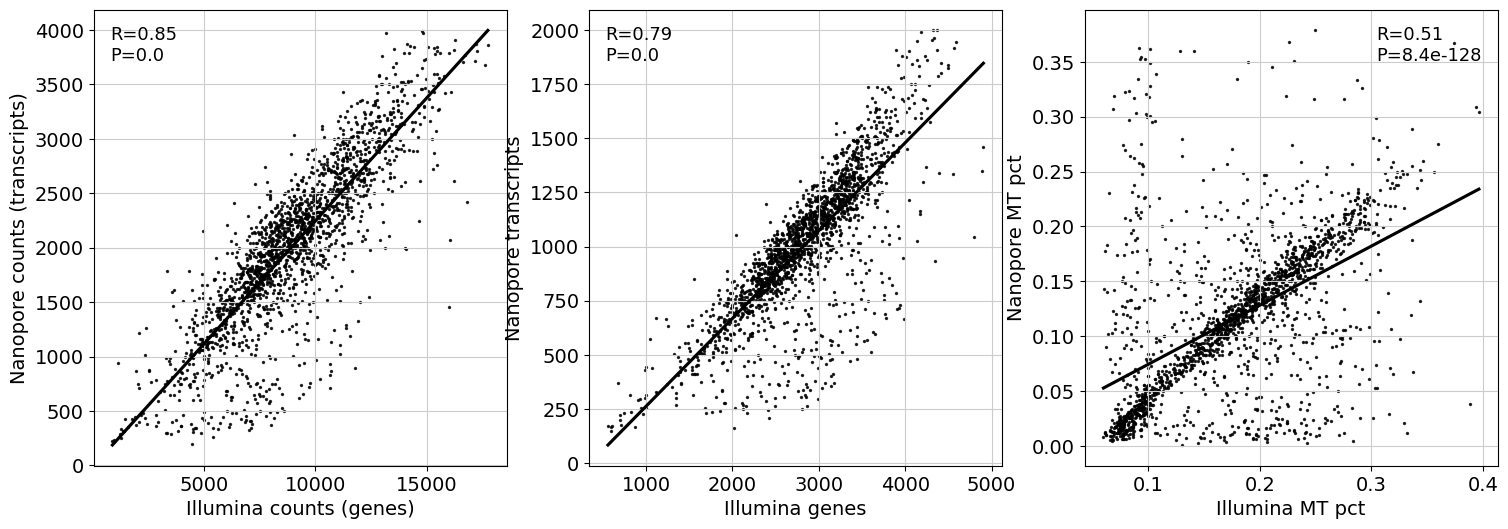

In [141]:
for lid1, lid2 in zip(['A1', 'B1', 'C1', 'D1'], ['H61211a', 'H61211b', 'H61211c', 'H61211d']):
    
    
    a = illumina_matching.obs[illumina_matching.obs.library_id==lid1].copy()
    a = a[['n_counts', 'n_genes', 'pct_mt']]
    a.rename(columns={'n_counts': 'Illumina counts (genes)', 'n_genes': 'Illumina genes', 'pct_mt': 'Illumina MT pct'}, inplace=True)
    
    b = adata_matching.obs[adata_matching.obs.library_id==lid2].copy()
    b = b[['n_counts', 'n_transcripts', 'pct_mt']]
    b.rename(columns={'n_counts': 'Nanopore counts (transcripts)', 'n_transcripts': 'Nanopore transcripts', 'pct_mt': 'Nanopore MT pct'}, inplace=True)

    data = pd.concat([a, b], axis=1)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina counts (genes)'],data['Nanopore counts (transcripts)'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina counts (genes)", y="Nanopore counts (transcripts)", data=data, ax=ax1,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)

    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina genes'],data['Nanopore transcripts'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina genes", y="Nanopore transcripts", data=data, ax=ax2,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)


    slope, intercept, r_value, pv, se = stats.linregress(data['Illumina MT pct'],data['Nanopore MT pct'])
    # sns.regplot(x="Illumina_counts", y="Nanopore_counts", data=data, 
    #       ci=None, label="y={0:.1f}x+{1:.1f}".format(slope, intercept), color='k', scatter_kws={'s':2}).legend(loc="best")
    sns.regplot(x="Illumina MT pct", y="Nanopore MT pct", data=data, ax=ax3,
          ci=None, label="R={0:.2}\nP={1:.2}".format(r_value, pv), color='k', scatter_kws={'s':2}).legend(loc="best", frameon=False)

    leg = ax3.legend(handlelength=0, handletextpad=0, fancybox=False, frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)

    # filen = os.path.join(figloc, f"Illumina_vs_Nanopore_scatter_{illumina_matching.shape[0]}matching_barcodes.png")
    filen = os.path.join(outloc, 'results', 'figures', f"Illumina_vs_Nanopore_scatter_{lid1}.png")
    fig.savefig(filen, bbox_inches = "tight")
    

In [150]:
# label transfer

In [150]:
illumina.obs.clusters.unique()

['2', '0', '3', '1']
Categories (4, object): ['2', '0', '3', '1']

In [173]:
# merge before - redo no nromalisation sop far, no clustering
# first concatenate - 
# combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    join='inner', 
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            slides[0].uns["spatial"],
            slides[1].uns["spatial"],
            slides[2].uns["spatial"],
            slides[3].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)
adata

AnnData object with n_obs × n_vars = 7422 × 17406
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'n_genes', 'library_id'
    var: 'feature_types', 'genome', 'qry_id', 'qry_gene_id', 'ref_gene_name', 'class_code', 'ref_id-H61211a', 'ref_gene_id-H61211a', 'n_cells-H61211a', 'ref_id-H61211b', 'ref_gene_id-H61211b', 'n_cells-H61211b', 'ref_id-H61211c', 'ref_gene_id-H61211c', 'n_cells-H61211c', 'ref_id-H61211d', 'ref_gene_id-H61211d', 'n_cells-H61211d'
    uns: 'spatial'
    obsm: 'spatial'

In [175]:
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [165]:
# we tried clustering before, so remove
# adata.obs.drop(columns=['clusters', 'leiden_rr'], inplace=True)
# adata.obs.drop(columns=['clusters'], inplace=True)

In [176]:
# load latest Illumina results
filen = '/prj/Florian_Leuschner_spatial/analysis/Illumina/data/clusters_bbknn.h5ad'
illumina = sc.read_h5ad(filen)

# use all nanopore, assign those labels that "match"
# assign Unknown to remaining

# # DECIDE WHICH ONE...
# # we should reformat this into the h5 object 
adata.obs_names = adata.obs_names.str.replace('H61211a', 'A1')
adata.obs_names = adata.obs_names.str.replace('H61211b', 'B1')
adata.obs_names = adata.obs_names.str.replace('H61211c', 'C1')
adata.obs_names = adata.obs_names.str.replace('H61211d', 'D1')

obs = illumina.obs.reindex(adata.obs.index)
adata.obs = adata.obs.join(obs[['clusters']])
    
cat = adata.obs.clusters.cat.categories.values
cat = np.append(cat, 'Unknown')

adata.obs["seed_labels"] = adata.obs.clusters.values
adata.obs["seed_labels"] = pd.Categorical(adata.obs["seed_labels"], categories=cat)

adata.obs.fillna({'seed_labels': 'Unknown'}, inplace=True)
adata.obs.seed_labels.value_counts()

# add this information to the adata 
flag = np.array(adata.shape[0] * [0])
flag[adata.obs["seed_labels"]=='Unknown'] = 1
adata.obs["nanopore_only"] = flag


0          2563
1          2302
2          1463
3          1065
Unknown      29
Name: seed_labels, dtype: int64

In [177]:
adata.obs

in_tissue  array_row  array_col     n_counts  \
AAACAAGTATCTCCCA-1-A1          1         50        102   181.000000   
AAACATTTCCCGGATT-1-A1          1         61         97   973.999023   
AAACCGGGTAGGTACC-1-A1          1         42         28  1086.000977   
AAACCTAAGCAGCCGG-1-A1          1         65         83   703.999023   
AAACCTCATGAAGTTG-1-A1          1         37         19   779.000000   
...                          ...        ...        ...          ...   
TTGTTAGCAAATTCGA-1-D1          1         22         42  2839.561035   
TTGTTCAGTGTGCTAC-1-D1          1         24         64  1276.613037   
TTGTTGTGTGTCAAGA-1-D1          1         31         77  1168.779053   
TTGTTTCACATCCAGG-1-D1          1         58         42  3033.705078   
TTGTTTCCATACAACT-1-D1          1         45         27  2998.486084   

                       n_transcripts    pct_mt  n_genes library_id clusters  \
AAACAAGTATCTCCCA-1-A1            146  0.056691      146    H61211a        2   
AAACATTTCCCGGATT-1-A1            626  0.027239      626    H61211a        2   
AAACCGGGTAGGTACC-1-A1            381  0.301293      381    H61211a        0   
AAACCTAAGCAGCCGG-1-A1            450  0.103874      450    H61211a        3   
AAACCTCATGAAGTTG-1-A1            309  0.334920      309    H61211a        0   
...                              ...       ...      ...        ...      ...   
TTGTTAGCAAATTCGA-1-D1           1378  0.032522     1378    H61211d        1   
TTGTTCAGTGTGCTAC-1-D1            806  0.010544      806    H61211d        3   
TTGTTGTGTGTCAAGA-1-D1            573  0.302586      573    H61211d        2   
TTGTTTCACATCCAGG-1-D1           1102  0.274434     1102    H61211d        1   
TTGTTTCCATACAACT-1-D1           1232  0.077020     1232    H61211d        0   

                      seed_labels  nanopore_only  
AAACAAGTATCTCCCA-1-A1           2              0  
AAACATTTCCCGGATT-1-A1           2              0  
AAACCGGGTAGGTACC-1-A1           0              0  
AAACCTAAGCAGCCGG-1-A1           3              0  
AAACCTCATGAAGTTG-1-A1           0              0  
...                           ...            ...  
TTGTTAGCAAATTCGA-1-D1           1              0  
TTGTTCAGTGTGCTAC-1-D1           3              0  
TTGTTGTGTGTCAAGA-1-D1           2              0  
TTGTTTCACATCCAGG-1-D1           1              0  
TTGTTTCCATACAACT-1-D1           0              0  

[7422 rows x 11 columns]

In [179]:
# register AnnData for use in scANVI
scvi.data.setup_anndata(adata, batch_key=None, labels_key="seed_labels") #layer="counts"
scvi_model = scvi.model.SCVI(adata, n_latent=15, n_layers=2) # same set-up as before
scvi_model.train()

INFO     No batch_key inputted, assuming all cells are same batch                            


/home/eboileau/.virtualenvs/sc3.9_spatial/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)
INFO     : No batch_key inputted, assuming all cells are same batch


INFO     Using labels from adata.obs["seed_labels"]                                          


INFO     : Using labels from adata.obs["seed_labels"]


INFO     Using data from adata.X                                                             


INFO     : Using data from adata.X


INFO     Successfully registered anndata object containing 7422 cells, 17406 vars, 1 batches,
         5 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO     : Successfully registered anndata object containing 7422 cells, 17406 vars, 1 batches, 5 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


INFO     : Please do not further modify adata until model is trained.
INFO     : GPU available: False, used: False
INFO     : TPU available: False, using: 0 TPU cores


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/eboileau/.virtualenvs/sc3.9_spatial/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [25:32<00:00,  3.83s/it, loss=2.49e+03, v_num=1]


In [180]:
# train scANVI and transfer the labels
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')
scanvi_model.train(25) # follow example use 25

INFO     Training for 25 epochs.                                                             


/home/eboileau/.virtualenvs/sc3.9_spatial/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
INFO     : Training for 25 epochs.
INFO     : GPU available: False, used: False
INFO     : TPU available: False, using: 0 TPU cores


Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]

/home/eboileau/.virtualenvs/sc3.9_spatial/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/25: 100%|██████████| 25/25 [02:11<00:00,  5.24s/it, loss=2.49e+03, v_num=1]


In [181]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)
adata

/home/eboileau/.virtualenvs/sc3.9_spatial/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 7422 × 17406
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'n_genes', 'library_id', 'clusters', 'seed_labels', 'nanopore_only', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'feature_types', 'genome', 'qry_id', 'qry_gene_id', 'ref_gene_name', 'class_code', 'ref_id-H61211a', 'ref_gene_id-H61211a', 'n_cells-H61211a', 'ref_id-H61211b', 'ref_gene_id-H61211b', 'n_cells-H61211b', 'ref_id-H61211c', 'ref_gene_id-H61211c', 'n_cells-H61211c', 'ref_id-H61211d', 'ref_gene_id-H61211d', 'n_cells-H61211d'
    uns: 'spatial', '_scvi'
    obsm: 'spatial', 'X_scANVI'

In [183]:
# # keep the actual clusters from scNapBar assignemnt on the set of matched barcodes
# # and "transfer" the scANVI labels for the Nanopore-only barcodes
adata.obs.clusters.fillna(adata.obs.C_scANVI, inplace=True)

In [184]:
sc.pp.neighbors(adata, use_rep="X_scANVI") # use the scANVI representation
sc.tl.umap(adata, min_dist=0.1, spread=.6) #, init_pos='X_scANVI')


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [ ]:
# sc.pl.umap(adata, color=['batch', 'cluster', 'C_scANVI'])

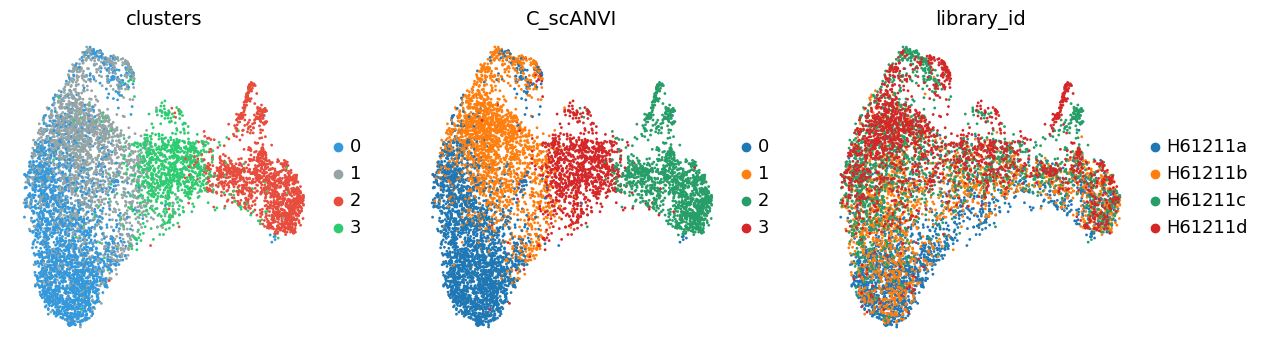

In [187]:
# adata.uns['clusters_colors'] = ["#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
sc.pl.umap(adata, color=["clusters",'C_scANVI', "library_id"], save=f'label_transferred_{outname}')

In [188]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata.uns["clusters_colors"])
)

[<AxesSubplot:title={'center':'H61211a'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211b'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211c'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211d'}, xlabel='spatial1', ylabel='spatial2'>]

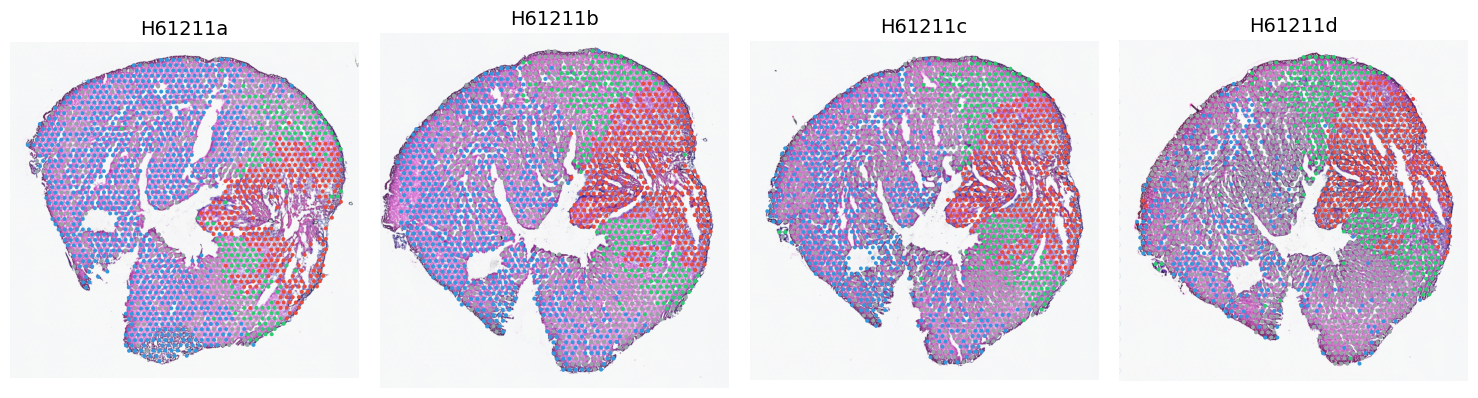

In [189]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))

for i, library in enumerate(
    ['H61211a', 'H61211b', 'H61211c', 'H61211d']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        title=library,
        #size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [190]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_clusters_label_transferred_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

In [191]:
adata

AnnData object with n_obs × n_vars = 7422 × 17406
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'n_genes', 'library_id', 'clusters', 'seed_labels', 'nanopore_only', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'feature_types', 'genome', 'qry_id', 'qry_gene_id', 'ref_gene_name', 'class_code', 'ref_id-H61211a', 'ref_gene_id-H61211a', 'n_cells-H61211a', 'ref_id-H61211b', 'ref_gene_id-H61211b', 'n_cells-H61211b', 'ref_id-H61211c', 'ref_gene_id-H61211c', 'n_cells-H61211c', 'ref_id-H61211d', 'ref_gene_id-H61211d', 'n_cells-H61211d'
    uns: 'spatial', '_scvi', 'neighbors', 'umap', 'clusters_colors', 'C_scANVI_colors', 'library_id_colors'
    obsm: 'spatial', 'X_scANVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [192]:
filen = os.path.join(outloc, 'data', f"clusters_{outname}.h5ad")
adata.write_h5ad(filen)

In [ ]:
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################

In [ ]:
# BYGONE - 25.01.2021

## Normalisation

We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes. 
The variance in molecular counts across spots is not just technical in nature, but also is dependent on the tissue anatomy.
More appropriate methods such as SCTransform should probably be used.


### BBKNN Integration

BBKNN has the option to immediately slot into the spot occupied by scanpy.neighbors()

You can provide which adata.obs column to use for batch discrimination via the batch_key parameter. This defaults to 'batch', which is created by scanpy when you merge multiple AnnData objects (e.g. if you were to import multiple samples separately and then concatenate them).



In [93]:
# first concatenate - 
# combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    join='inner', 
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            slides[0].uns["spatial"],
            slides[1].uns["spatial"],
            slides[2].uns["spatial"],
            slides[3].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [94]:
# save the counts in case, we need the normalized counts in raw for DGE
counts_adata = adata.copy()

# Normalization standard workflow
target_sum = 1e4
sc.pp.normalize_total(adata, 
                      target_sum=target_sum, 
                      exclude_highly_expressed=True)
sc.pp.log1p(adata)

# the idea is to avoid including batch specific genes in the analysis.
sc.pp.highly_variable_genes(adata, batch_key="library_id")

# subset for variable genes - do this beforehand if subset=True to keep full dimension safe
# and in any case, before filtering for HVG
adata.raw = adata

logger.info(f"View of AnnData object with n_obs × n_vars {adata.shape}")

# keep the union
adata = adata[:,adata.var.highly_variable_nbatches > 0]
# or e.g. genes that are variable in at least 2 datasets
# adata = adata[:,adata.var.highly_variable_nbatches > 2]

logger.info(f"View of AnnData object with n_obs × n_vars {adata.shape}")

# we should update QC metrics after filtering!
# here

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['MSTRG.72.6:Col19a1', 'MSTRG.73.2:Col19a1', 'MSTRG.73.3:Col19a1', 'MSTRG.7712.1:Gm42418', 'ENSMUST00000103230:Nppa', 'MSTRG.18711.1:mt-Cytb', 'MSTRG.18712.1:mt-Nd6', 'MSTRG.18712.4:mt-Nd6', 'ENSMUST00000084013:mt-Nd4', 'ENSMUST00000033582:Cox7b']
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
INFO     : View of AnnData object with n_obs × n_vars (7422, 17406)
INFO     : View of AnnData object with n_obs × n_vars (7422, 11021)


In [95]:
adata

View of AnnData object with n_obs × n_vars = 7422 × 11021
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'n_genes', 'library_id'
    var: 'feature_types', 'genome', 'qry_id', 'qry_gene_id', 'ref_gene_name', 'class_code', 'ref_id-H61211a', 'ref_gene_id-H61211a', 'n_cells-H61211a', 'ref_id-H61211b', 'ref_gene_id-H61211b', 'n_cells-H61211b', 'ref_id-H61211c', 'ref_gene_id-H61211c', 'n_cells-H61211c', 'ref_id-H61211d', 'ref_gene_id-H61211d', 'n_cells-H61211d', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [96]:
adata.raw.shape

(7422, 17406)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


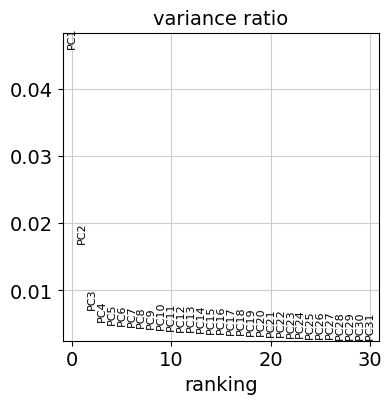

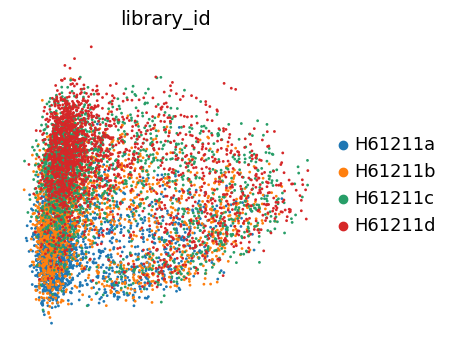

In [97]:
sc.tl.pca(adata, 
          svd_solver='arpack', 
          use_highly_variable=True)

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color="library_id")

In [98]:
# improved batch mixing by introducing ridge regression into the workflow
# Regressing out technical effect while including a biological grouping into the procedure is 
# insufficient to remove batch effect from a UMAP based on a regular neighbour graph, but helps mix batches
# better when used as input for BBKNN. One may not be armed in a biological grouping at the time of analysis, in which 
# case a coarse clustering (aiming to feature as many batches as possible per cluster) can be used in its place. This results in the following analysis flow:
# bbknn
# clustering
# ridge regression
# pca
# bbknn

# e.g. https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/demo.ipynb
# other exmaples at https://github.com/Teichlab/bbknn

# see also e.g. ~/runs/LZ_PR2B_rewiring/notebooks/analysis_merged_prelim/analysis_merged_prelim.ipynb

# after bnknn  `.X` now features regression residuals
# `.layers['X_explained']` stores the expression explained by the technical effect

# >> use copy=True when calling to copy object and keep adata safe for comparison

n_pcs = 10

bbknn.bbknn(adata, batch_key='library_id', neighbors_within_batch=15, n_pcs=n_pcs, trim=20)

resolution = 0.4
key_added = 'leiden_rr'

sc.tl.leiden(adata, 
             resolution=resolution, 
             key_added=key_added)
bbknn.ridge_regression(adata, batch_key=['library_id'], confounder_key=['leiden_rr'])
sc.tl.pca(adata, 
          svd_solver='arpack', 
          use_highly_variable=True) # reuse same number of components here
bbknn.bbknn(adata, batch_key='library_id', neighbors_within_batch=15, n_pcs=n_pcs, trim=20)


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_rr', the cluster labels (adata.obs, categorical) (0:00:00)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Neighbours - Clustering

In [99]:
# BBKNN replaced neighbours
sc.tl.umap(adata, min_dist=0.1, spread=.6)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [101]:
resolution = 0.2
sc.tl.leiden(adata, 
             resolution=resolution, 
             key_added="clusters")
adata.obs['clusters'].value_counts()

running Leiden clustering
    finished: found 4 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


0    2339
1    2091
2    2069
3     923
Name: clusters, dtype: int64

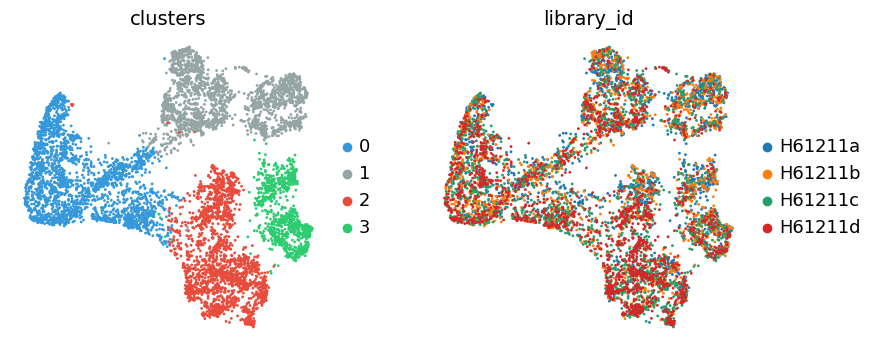

In [102]:
adata.uns['clusters_colors'] = ["#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
sc.pl.umap(adata, color=["clusters", "library_id"])

In [103]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata.uns["clusters_colors"])
)

[<AxesSubplot:title={'center':'H61211a'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211b'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211c'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'H61211d'}, xlabel='spatial1', ylabel='spatial2'>]

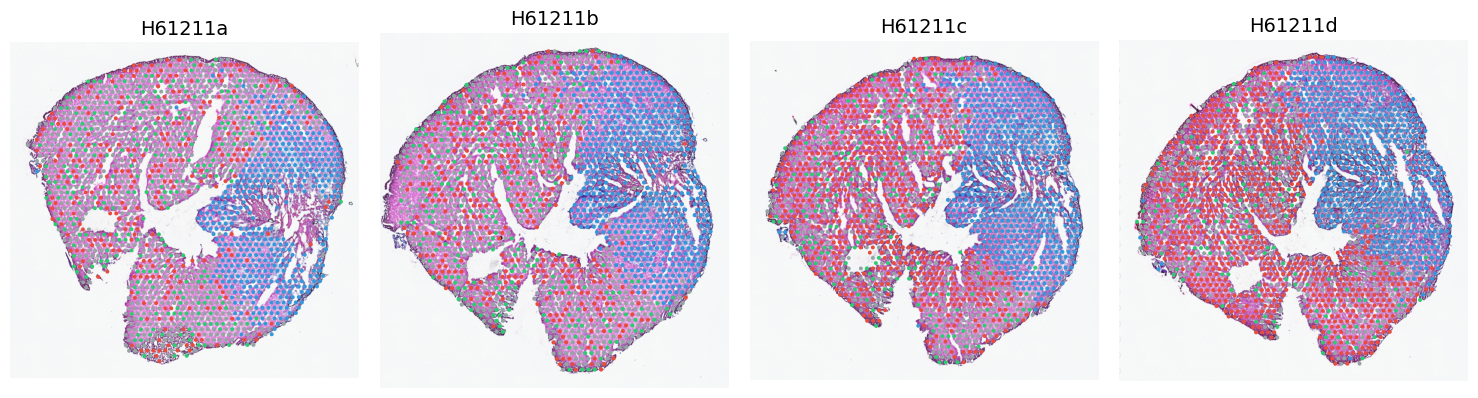

In [106]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))

for i, library in enumerate(
    ['H61211a', 'H61211b', 'H61211c', 'H61211d']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        title=library,
        #size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [107]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_clusters_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

[<AxesSubplot:title={'center':'A1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'B1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'C1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'D1'}, xlabel='spatial1', ylabel='spatial2'>]

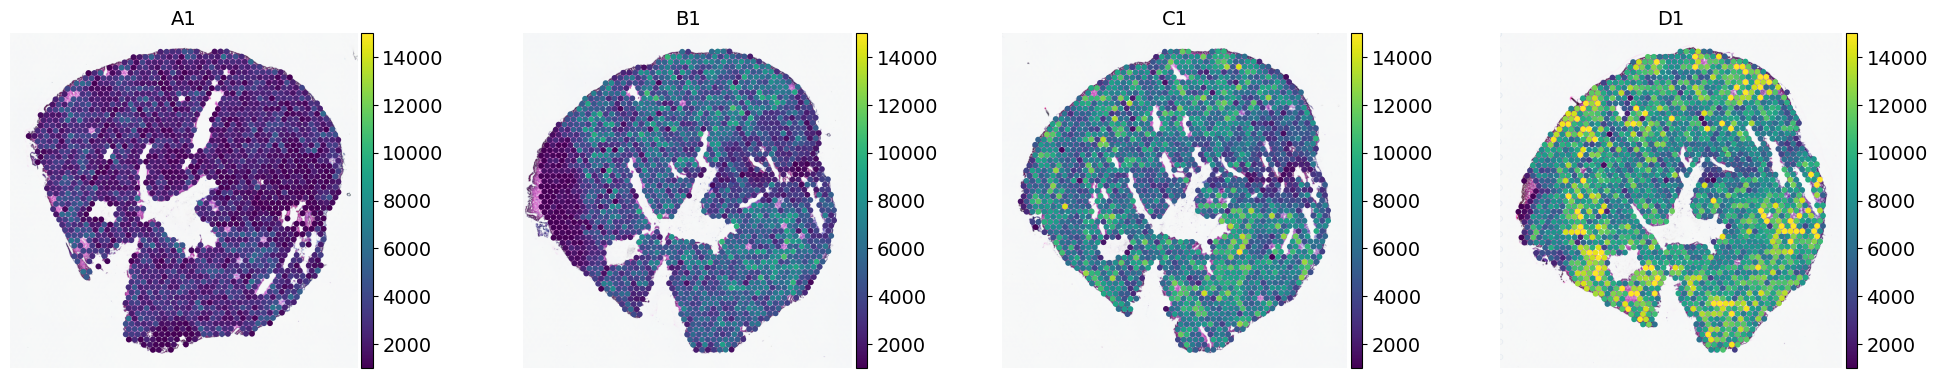

In [98]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, library in enumerate(
    ['A1', 'B1', 'C1', 'D1']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="n_counts",
        size=1.5,
        title=library,
        vmin=1000,
        vmax=15000,
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [99]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_counts_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

[<AxesSubplot:title={'center':'A1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'B1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'C1'}, xlabel='spatial1', ylabel='spatial2'>]

[<AxesSubplot:title={'center':'D1'}, xlabel='spatial1', ylabel='spatial2'>]

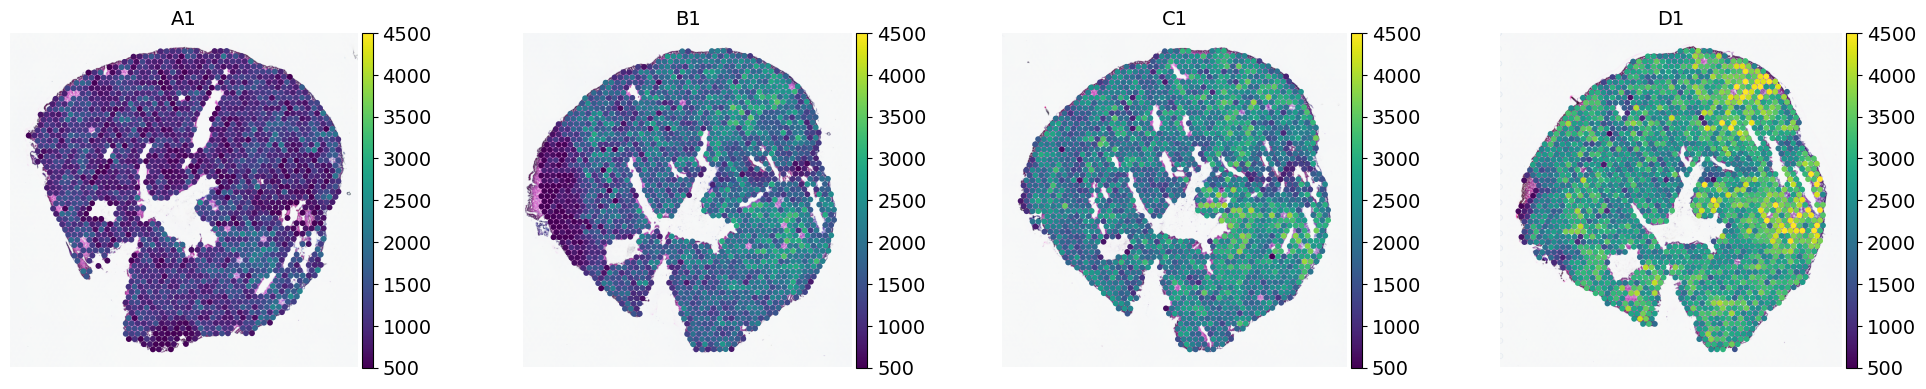

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, library in enumerate(
    ['A1', 'B1', 'C1', 'D1']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="n_genes",
        size=1.5,
        title=library,
        vmin=500,
        vmax=4500,
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

In [101]:
filen = os.path.join(outloc, 'results', 'figures', f"spatial_genes_{outname}.png")
fig.savefig(filen, bbox_inches = "tight")

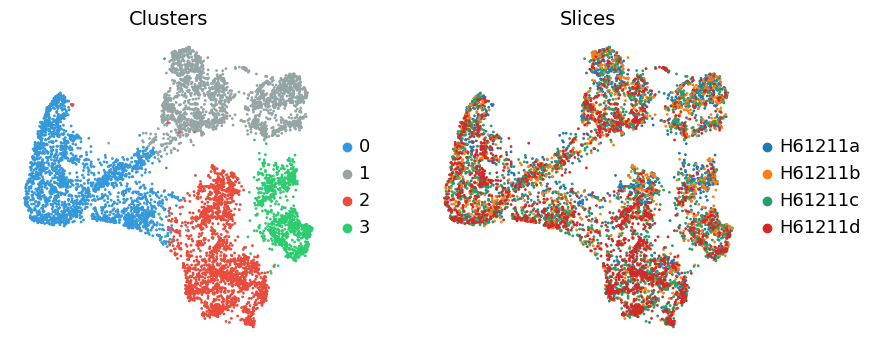

In [108]:
sc.pl.umap(adata, color=["clusters", "library_id"], title=['Clusters', 'Slices'], save=f'_{outname}.png')

## Data integration and label transfer from scRNA-seq dataset (perform label transfers between an annotated scRNA-seq dataset and an unannotated Visium dataset)

Workflow: (i) The integration task will be performed with Scanorama: each Visium dataset can be integrated with a given scRNA-seq dataset, (ii) Subset the spatial anndata to (approximately) selects only spots belonging to the region relevant to the scRNA-seq if applicable, (iii) Run integration with Scanorama, and (iv) Concatenate datasets and assign integrated embeddings to anndata objects.

See [Data integration and label transfer from scRNA-seq dataset](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html#Data-integration-and-label-transfer-from-scRNA-seq-dataset).

For label transfer, deconvolution methods can also be used, but see https://satijalab.org/seurat/articles/spatial_vignette.html

*We consistently found superior performance using integration methods (as opposed to deconvolution methods).
We therefore apply the ‘anchor’-based integration workflow introduced in Seurat v3, that enables the probabilistic transfer of annotations from a reference to a query set. We first load the (reference scRNA-seq) data, pre-process the scRNA-seq reference, and then perform label transfer.*


## Marker genes & cluster annotation

Use the Visium data only, and selected known markers.


In [103]:
# our markers
with open("/home/eboileau/resources/markers.json", "r") as f:
    all_markers = json.load(f)
all_markers = json.loads(all_markers)

# collect selected markers, incl. human
selected_markers = defaultdict(set)

for m in ['CM', 'FB']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][0]['markers'][m]])
    
for m in all_markers['heart'][1]['markers'].keys():
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][1]['markers'][m]])
    
for m in ['EC', 'FB', 'NC', 'SMC', 'PC', 'MC', 'AC']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][2]['markers']['markers_canonical'][m]])
# drop all_markers['heart'][2]['markers']['markers_immune'].keys()

for m in ['PC', 'MP', 'AC', 'SMC', 'NC', 'LC']:
    selected_markers[m].update([g.lower().capitalize() for g in all_markers['heart'][3]['markers'][m]])
    
for m in ['VP', 'EC', 'FB', 'PC', 'MP', 'MY', 'LC', 'AC', 'NC', 'MC', 'SMC']:
    selected_markers[m].update(all_markers['heart'][4]['markers'][m])
    
selected_markers.keys()
# all_markers['description']

dict_keys(['CM', 'FB', 'EC', 'MP', 'SMC', 'NC', 'PC', 'MC', 'AC', 'LC', 'VP', 'MY'])

In [104]:
# after a first check, we subset the most relevant for/expressed in our data
for key in selected_markers.keys():
    selected_markers[key] = {m for m in selected_markers[key] if m in adata.raw.var_names}
    

In [105]:
markers = {'CM': ['Tnnt2', 'Myl2', 'Myl3', 'Myh6', 'Myh7', 'Ttn', 'Actc1', 'Actn2', 'Fabp3', 'Nppa', 'Ankrd1'],
           'MFB': ['Col1a2', 'Acta2', 'Igfbp7', 'Vim', 'Serpinh1', 'Fbln2', 'Sparc', 'Fn1'],
           'EC': ['Postn', 'Tmsb10', 'Cdh5', 'Pecam1'],
           'IM': ['Lyz2', 'C1qa', 'C1qb', 'Cd47', 'Cd74', 'Cd36', 'B2m']}

In [106]:
markers['Fibrosis'] = ['Nlrp3', 'Mmp2', 'Mmp6', 'Ccn2', 'Ctgf', 'Agt']
markers['Fibrosis'] = [a for a in markers['Fibrosis'] if a in adata.var_names]
markers['Fibroblast'] = ['Tcf21', 'Wt1', 'Tbx18', 'Tie2']
markers['Fibroblast'] = [a for a in markers['Fibroblast'] if a in adata.var_names]
markers['Inflammation'] = ['Hck', 'Cd53', 'Tyrobp', 'Clu']
markers['Inflammation'] = [a for a in markers['Inflammation'] if a in adata.var_names]
markers

# Mmp2, Ccn2 - fibrosis/inflammation
# Clu
# Highly consistent driver genes such as HCK, CD53 and TYROBP have been found being involved in many inflammation-related disorders.
# Clu
# genes critical for cardiac fibrosis were examined, namely, 
# Transcription factors that have been used as cardiac fibroblast markers include Tcf21, WT1, Tbx18, and Tie2

{'CM': ['Tnnt2',
  'Myl2',
  'Myl3',
  'Myh6',
  'Myh7',
  'Ttn',
  'Actc1',
  'Actn2',
  'Fabp3',
  'Nppa',
  'Ankrd1'],
 'MFB': ['Col1a2',
  'Acta2',
  'Igfbp7',
  'Vim',
  'Serpinh1',
  'Fbln2',
  'Sparc',
  'Fn1'],
 'EC': ['Postn', 'Tmsb10', 'Cdh5', 'Pecam1'],
 'IM': ['Lyz2', 'C1qa', 'C1qb', 'Cd47', 'Cd74', 'Cd36', 'B2m'],
 'Fibrosis': ['Mmp2', 'Ccn2', 'Agt'],
 'Fibroblast': ['Tcf21', 'Wt1', 'Tbx18'],
 'Inflammation': ['Hck', 'Cd53', 'Tyrobp']}

ranking genes
    finished: added to `.uns['ranked_clusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)


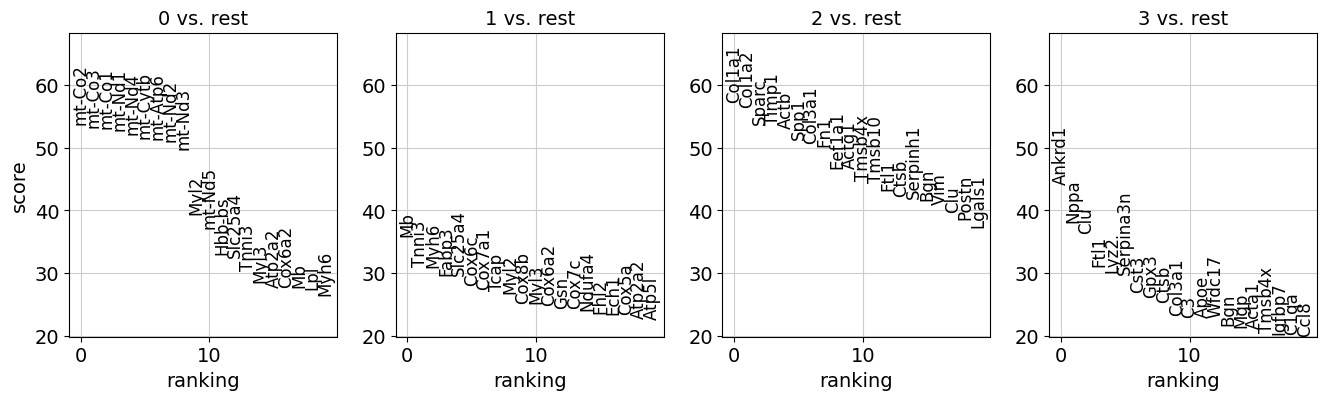

In [107]:
key_added = 'clusters'
sc.tl.rank_genes_groups(adata, 
                        groupby=key_added, 
                        key_added=f'ranked_{key_added}', 
                        method='wilcoxon', 
                        tie_correct=True,
                        use_raw=True)

sc.pl.rank_genes_groups(adata, 
                        key=f'ranked_{key_added}', 
                        fontsize=12,
                        save=f'_{outname}.png')

In [348]:
# wilcox_clusters = filter_by_expression(adata_spatial, 'clusters', key='ranked_clusters')
# wilcox_clusters.to_csv(os.path.join(dirloc, "results", "tables", f"wilcox_clusters_wide_{outname}.csv.gz"),
#                        index=False,
#                        compression='gzip')

In [109]:
dfl = []
for group in adata.uns['ranked_clusters']['names'].dtype.names:
    cols = {'names':adata.uns['ranked_clusters']['names'][group], 
            'scores':adata.uns['ranked_clusters']['scores'][group], 
            'pvals':adata.uns['ranked_clusters']['pvals'][group], 
            'pvals_adj':adata.uns['ranked_clusters']['pvals_adj'][group],
            'logfoldchanges':adata.uns['ranked_clusters']['logfoldchanges'][group],
            'clusters': group}
    dfl.append(pd.DataFrame(cols))
wilcox_clusters_long = pd.concat(dfl)
filen = os.path.join(outloc, "results", "tables", f"wilcox_clusters_long_std_{outname}.csv.gz")
wilcox_clusters_long.to_csv(filen, compression='gzip', index=False)

In [353]:
# sc.pl.rank_genes_groups_heatmap(adata_spatial, key='ranked_clusters', groups="2", n_genes=10, groupby="clusters")

In [114]:
sc.tl.dendrogram(adata, 'clusters', use_rep='X_pca')

Storing dendrogram info using `.uns['dendrogram_clusters']`


Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.2, max_out_group_fraction: 0.5


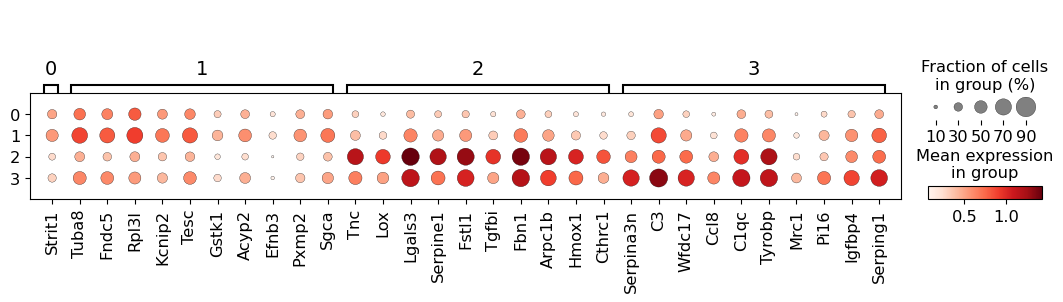

In [115]:
## Filtering of marker genes
sc.tl.filter_rank_genes_groups(adata,
                               key='ranked_clusters',
                               min_in_group_fraction=0.25,
#                                max_out_group_fraction=0.1,
                               min_fold_change=.2)
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_filtered', dendrogram=False)

categories: 0, 1, 2, etc.
var_group_labels: CM, FB, EC, etc.


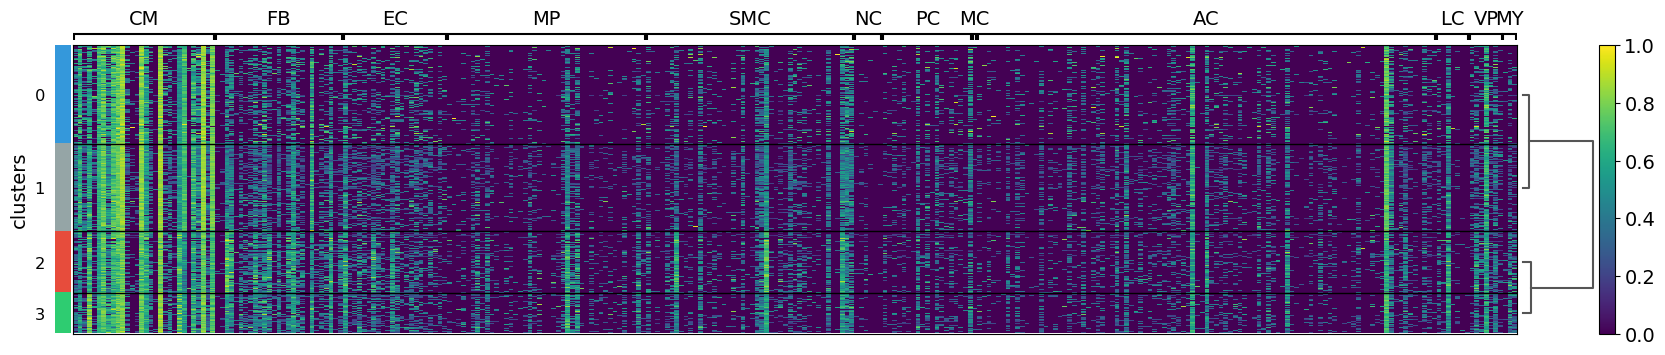

In [116]:
# sc.pl.rank_genes_groups_heatmap(adata_spatial, n_genes=10, key='ranked_clusters', show_gene_labels=True, dendrogram=False)
sc.pl.heatmap(
    adata,
    selected_markers,
    groupby='clusters',
    #layer="X_normalized_scVI",
    standard_scale="var",
    dendrogram=True,
    use_raw=True,
    figsize=(20, 4)
)

In [379]:
all_markers['description']

{'aCM': 'atrial cardiomyocyte',
 'vCM': 'ventricular cardiomyocyte',
 'CM': 'cardiomyocyte',
 'sCM': 'stressed cardiomyocyte',
 'FB': 'fibroblast',
 'EC': 'endothelial',
 'AC': 'adipocyte',
 'SMC': 'smooth muscle',
 'NC': 'neural crest',
 'LC': 'lymphocyte',
 'MP': 'macrophage',
 'PC': 'pericyte',
 'MC': 'mesothelial',
 'MY': 'myeloid',
 'VP': 'vascular progenitor',
 'AP': 'ion channels contributing to cardiac action potential',
 'GJ': 'heart gap junction channels',
 'PSC': 'pluripotent stem cells',
 'ENDO': 'definitive endoderm',
 'MESO': 'mesoderm',
 'ECTO': 'ectoderm',
 'NP': 'neural progenitor',
 'CP': 'cardiac progenitor'}

In [ ]:
# ax = sc.pl.stacked_violin(adata_spatial, selected_markers, groupby='clusters', swap_axes=True,
#                          var_group_positions=[(7, 8)], dendrogram=False)

categories: 0, 1, 2, etc.
var_group_labels: CM, MFB, EC, etc.


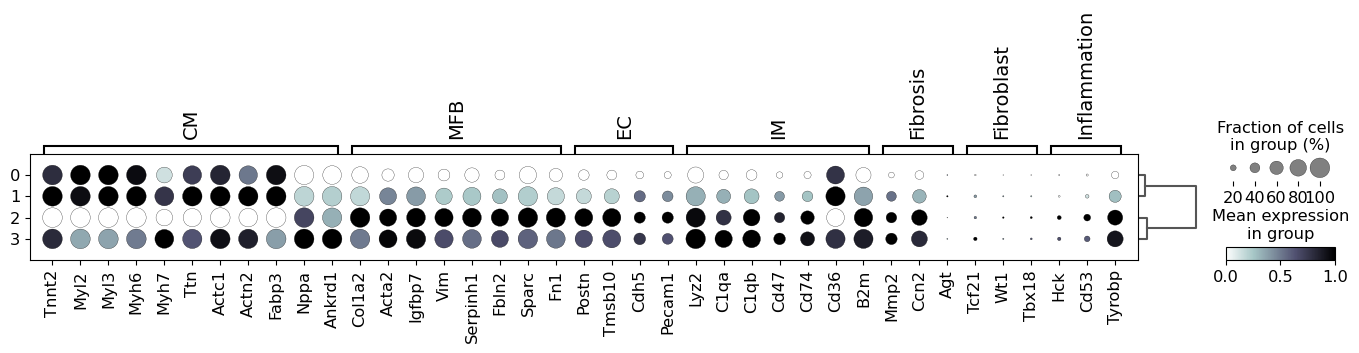

In [117]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='clusters',
    dendrogram=True,
    color_map=bone_reversed,
    swap_axes=False,
    use_raw=True, 
    standard_scale="var",
    save=f'_selected_markers_{outname}.png'
)

0     1     2     3
CM   23.0  25.0   4.0  10.0
FB    5.0   3.0  17.0  24.0
EC    7.0  10.0  11.0   9.0
MP   18.0   3.0  31.0  23.0
SMC  28.0  13.0  17.0  12.0
NC    5.0   0.0   1.0   1.0
PC   14.0  12.0   5.0   3.0
MC    1.0   0.0   0.0   0.0
AC   70.0  37.0  33.0  18.0
LC    4.0   0.0   6.0   3.0
VP    3.0   6.0   2.0   1.0
MY    0.0   0.0   3.0   3.0

<AxesSubplot:>

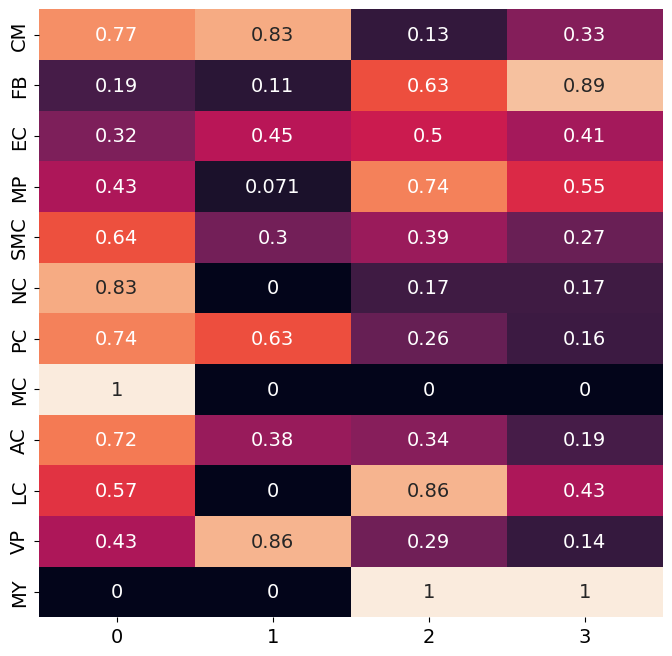

In [119]:
cell_annotation = sc.tl.marker_gene_overlap(adata, selected_markers, key='ranked_clusters',
                                            adj_pval_threshold=1e-5)
cell_annotation

cell_annotation_norm = sc.tl.marker_gene_overlap(adata, selected_markers, key='ranked_clusters', 
                                                 normalize='reference', adj_pval_threshold=1e-5)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cell_annotation_norm, cbar=False, annot=True, ax=ax)

0    1    2    3
CM            8.0  9.0  2.0  5.0
MFB           0.0  0.0  8.0  8.0
EC            0.0  0.0  4.0  2.0
IM            1.0  1.0  6.0  6.0
Fibrosis      1.0  0.0  2.0  2.0
Fibroblast    3.0  0.0  1.0  1.0
Inflammation  0.0  0.0  3.0  3.0

<AxesSubplot:>

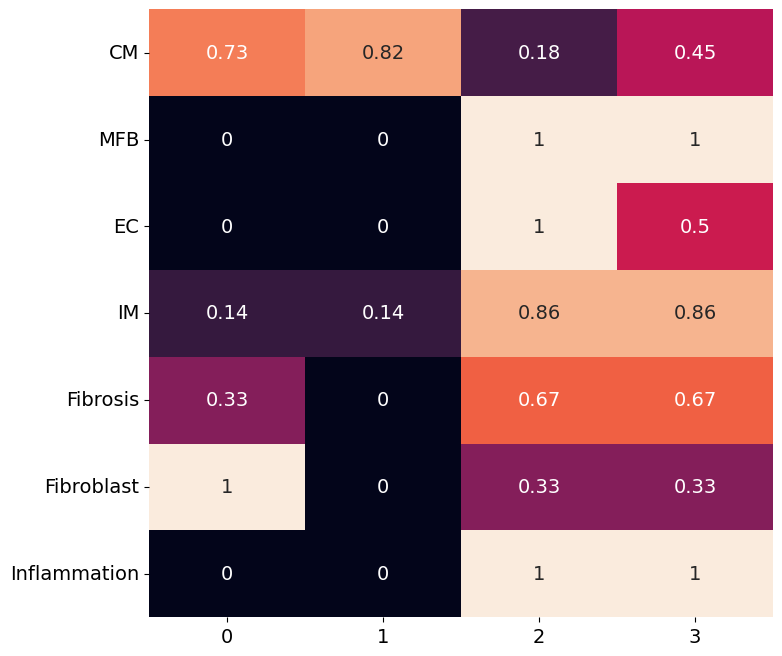

In [120]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers, key='ranked_clusters',
                                            adj_pval_threshold=1e-5)
cell_annotation

cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers, key='ranked_clusters', 
                                                 normalize='reference', adj_pval_threshold=1e-5)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cell_annotation_norm, cbar=False, annot=True, ax=ax)

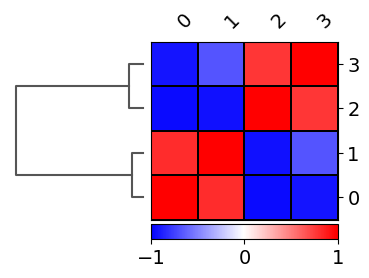

In [121]:
# we can check correlation between assigned clusters directly using
sc.pl.correlation_matrix(adata, 'clusters')

In [ ]:
# 0 = CM
# 1 = CM, fibroblast
# 2 = myofibroblast, endothelial, inflammation
# 3 = myofibroblast, inflammation

In [ ]:
# check some slices with known genes

In [122]:
# sc.pl.spatial(adata[adata.obs.library_id == 'A1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='A1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'B1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='B1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'C1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='C1', use_raw=True)
# sc.pl.spatial(adata[adata.obs.library_id == 'D1', :].copy(), img_key="hires", color=["clusters", "Col1a1", "Col1a2", "Col3a1"], library_id='D1', use_raw=True)

In [123]:
del adata.uns['rank_genes_groups_filtered']

In [124]:
# filen = os.path.join(outloc, "data", f"clusters_{outname}.h5ad")
# adata.write_h5ad(filen)

### Gene set analysis

In [125]:
import gseapy

In [126]:
# ranked gene groups - wilcoxon default
pval_cutoff = 0.05
log2fc_min = 0.2

gene_sets = 'GO_Biological_Process_2021'
title = "GO BP"

# gene_sets = 'GO_Molecular_Function_2021'
# title = "GO MF"

# specify gene background, see running locally with .gmt file or gene_set dict object ???
# otherwise enrichr default background='hsapiens_gene_ensembl'

# based on ranked gene groups as above use_raw=True

for idx in adata.obs.clusters.cat.categories:
    glist = sc.get.rank_genes_groups_df(adata, group=idx, key='ranked_clusters',
                                        pval_cutoff=pval_cutoff, log2fc_min=log2fc_min)['names'].squeeze().str.strip().tolist()
    enr_res = gseapy.enrichr(gene_list=glist,
                             organism='Mouse',
                             gene_sets=gene_sets,
                             description='pathway',
                             cutoff=0.01)

    filen = os.path.join(outloc, "results", "figures", f"clust{idx}_{gene_sets}_{outname}.png")
    gseapy.barplot(enr_res.res2d, title=f"{title}, Cluster {idx}", color=adata.uns['clusters_colors'][int(idx)], ofname=filen)
    
    

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:fe0cd5986c1c575610cd92eb2433d5d4
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:47b5884acf478dd691f8b6ffba4b05a2
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:f8f24f4440acf2f7bee6dd465fdce563
INFO     : Done.

INFO     : Connecting to Enrichr Server to get latest library names
INFO     : Analysis name: pathway, Enrichr Library: GO_Biological_Process_2021
INFO     : Save file of enrichment results: Job Id:98738860bb3d55633b6d40685c6edd8a
INFO     : Done.

